# Modelos

# Librerías y paquetes necesarios

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import lightgbm as lgb
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, GroupKFold, PredefinedSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import statsmodels.api as sm
import xgboost as xgb
import pickle
import joblib
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.metrics import classification_report
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.discrete.discrete_model import MNLogit 
from statsmodels.genmod.cov_struct import Independence
from statsmodels.genmod.generalized_estimating_equations import NominalGEE
from statsmodels.genmod.cov_struct import Independence
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from patsy import dmatrices
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.tools import add_constant

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
filepath = '/content/drive/My Drive/PYMES/finalpymes.xlsx'
data = pd.read_excel(filepath)

# Análisis

In [7]:
print(tabulate(data.head(10), headers = 'keys', tablefmt='pretty'))

+---+---------------------------+-----------+----------------------------------------+---------------------------------------------------+--------------------------------------------+--------------------------------+--------------------------------------------+----------------+-------------------------------------------------------------------------------------------+---------------------------+-----------------------------+--------------------+----------------------------------------+-------------------+----------------------+----------------------+-----------------------+----------------------+------------------------+----------------------+-------------+-------------------+-------------------+--------------------+---------------------+-------------------+-------------------+-------------------+-------------------+
|   |       Estado actual       |    NIT    | Concepto del Revisor fiscal en su orme | La compañía está obligada a tener Revisor fiscal? |              Tipo societario    

visualizamos las primeras 10 filas del conjunto de datos en un formato tabular bien estructurado, facilitando la interpretación de las variables y sus valores. 

In [8]:
print(f'Número de filas: {data.shape[0]}')
print(f'Número de columnas: {data.shape[1]}')

Número de filas: 141621
Número de columnas: 29


Se identificó que el dataset contiene 141,621 filas y 29 columnas,

**Filtramos el conjuto de datos**

Se filtra el conjunto de datos, seleccionando únicamente los registros donde la variable "SD" (Servicio de Deuda) es mayor a cero. Este filtro es esencial, ya que permite analizar exclusivamente a las empresas que efectivamente tienen un registro de deuda. En el análisis preliminar, se identificó que ciertas empresas mostraban valores extremadamente altos y positivos en métricas relacionadas con la capacidad de cubrir el servicio de deuda. 

In [35]:
datos_filtrados = data[(data['SD'] > 0)]

In [ ]:
data = datos_filtrados.copy()
len(data)

37168

El conjunto de datos contiene 37,168 registros después del filtrado. Este valor refleja la cantidad de observaciones relevantes que cumplen con los criterios establecidos, en este caso, aquellas empresas que tienen datos positivos en la variable "Servicio de Deuda" (SD).

**Tipos de variables**

In [ ]:
variable_types = data.dtypes.value_counts().reset_index()
variable_types.columns = ['Data Type', 'Count']

variable_types

Data Type  Count
0   float64     21
1    object      6
2     int64      2

Muestra que el dataset contiene 21 variables de tipo float64, 6 variables de tipo object y 2 variables de tipo int64

In [ ]:
def resumen_datos(data):
    resumen = []
    total_filas = len(data)

    for columna in data.columns:
        faltantes = data[columna].isnull().sum()
        ceros = (data[columna] == 0).sum()
        porcentaje_faltantes = (faltantes / total_filas) * 100
        supera_10 = "Sí" if porcentaje_faltantes > 10 else "No"

        resumen.append({
            "Columna": columna,
            "Faltantes": faltantes,
            "Ceros": ceros,
            "%Faltantes": f"{porcentaje_faltantes:.2f}%",
            "Supera 10%": supera_10
        })

    return pd.DataFrame(resumen)

In [ ]:
tabla_resumen = resumen_datos(data)
print(tabulate(tabla_resumen, headers='keys', tablefmt='grid'))

+----+----------------------------------------------------------------------+-------------+---------+--------------+--------------+
|    | Columna                                                              |   Faltantes |   Ceros | %Faltantes   | Supera 10%   |
+====+======================================================================+=============+=========+==============+==============+
|  0 | Estado actual                                                        |           0 |       0 | 0.00%        | No           |
+----+----------------------------------------------------------------------+-------------+---------+--------------+--------------+
|  1 | NIT                                                                  |           0 |       0 | 0.00%        | No           |
+----+----------------------------------------------------------------------+-------------+---------+--------------+--------------+
|  2 | Concepto del Revisor fiscal en su orme                               

Generamos un resumen detallado de las columnas del conjunto de datos, analizando valores faltantes, ceros y el porcentaje de faltantes para identificar posibles problemas de calidad. Los resultados muestran que las columnas tienen una baja incidencia de valores faltantes. Ninguna columna supera el umbral crítico del 10% de valores faltantes, lo que asegura que el conjunto de datos es lo suficientemente completo y adecuado para los procesos de modelado sin requerir imputación significativa de valores.

In [ ]:
num_valores_no_nulos = data["FDC/FLC"].notnull().sum()
print(f'Número de valores no nulos para FDC/FLC: {num_valores_no_nulos}')

Número de valores no nulos para FDC/FLC: 37168


#### Mirar por año datos faltantes

In [ ]:
def missing_data_by_year(df):
    missing_data_summary = []

    for year in data['Fecha de Corte'].unique():  
        year_data = data[data['Fecha de Corte'] == year]
        for col in data.columns:
            missing_count = year_data[col].isnull().sum()
            missing_percent = (missing_count / len(year_data)) * 100 if len(year_data) > 0 else 0
            missing_data_summary.append({
                'Year': year,
                'Column': col,
                'Missing Count': missing_count,
                'Missing Percentage': missing_percent
            })

    return pd.DataFrame(missing_data_summary)

missing_data_df = missing_data_by_year(data)
print(tabulate(missing_data_df, headers='keys', tablefmt='grid'))

+-----+--------+----------------------------------------------------------------------+-----------------+----------------------+
|     |   Year | Column                                                               |   Missing Count |   Missing Percentage |
+=====+========+======================================================================+=================+======================+
|   0 |   2017 | Estado actual                                                        |               0 |            0         |
+-----+--------+----------------------------------------------------------------------+-----------------+----------------------+
|   1 |   2017 | NIT                                                                  |               0 |            0         |
+-----+--------+----------------------------------------------------------------------+-----------------+----------------------+
|   2 |   2017 | Concepto del Revisor fiscal en su orme                               |          

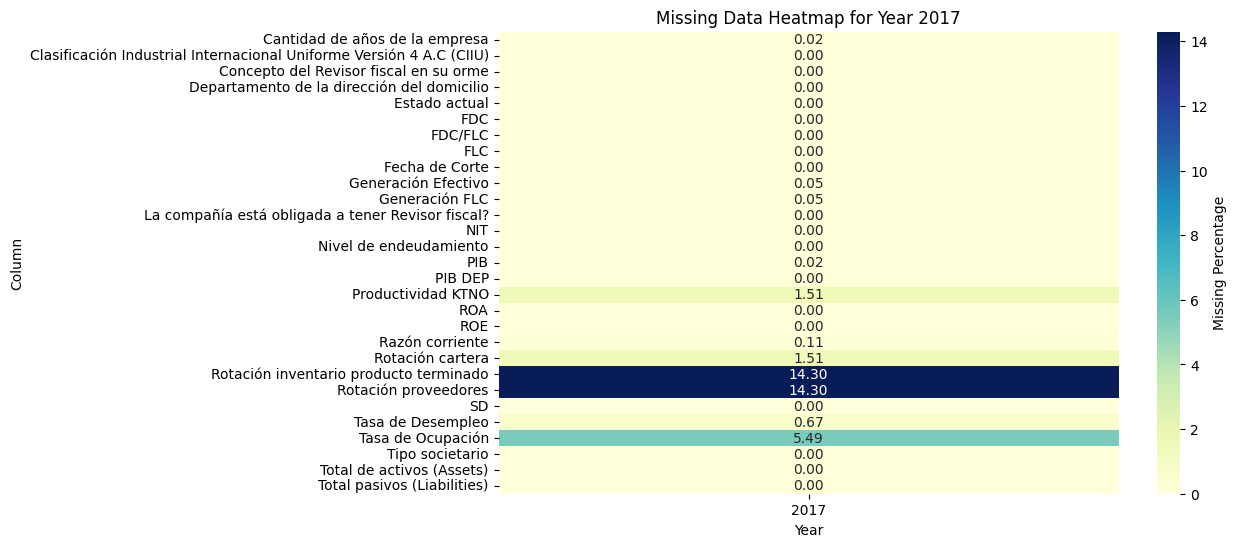

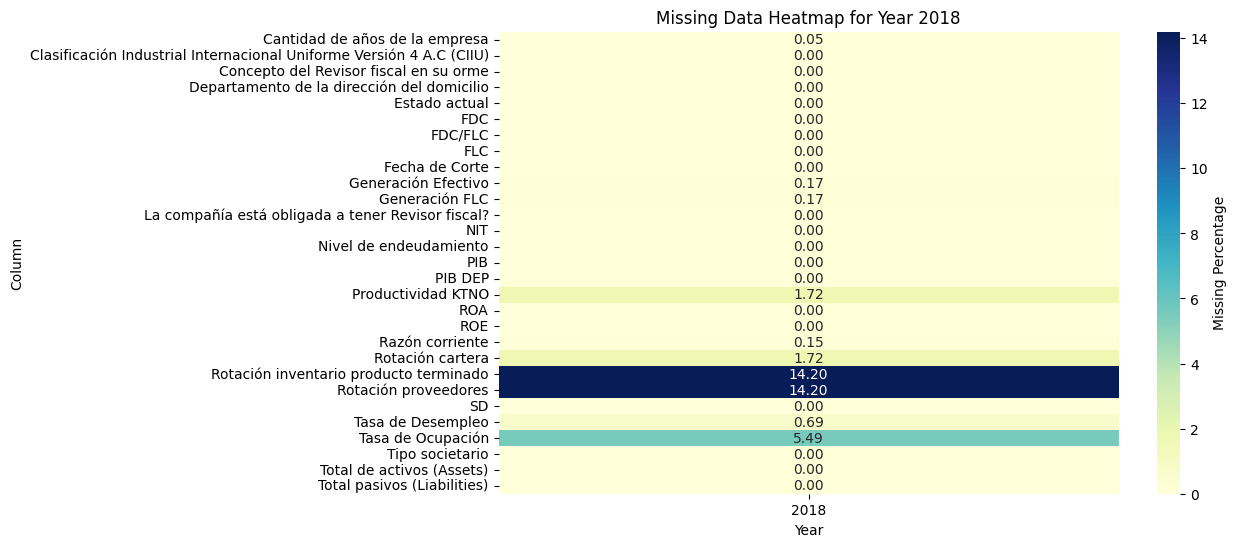

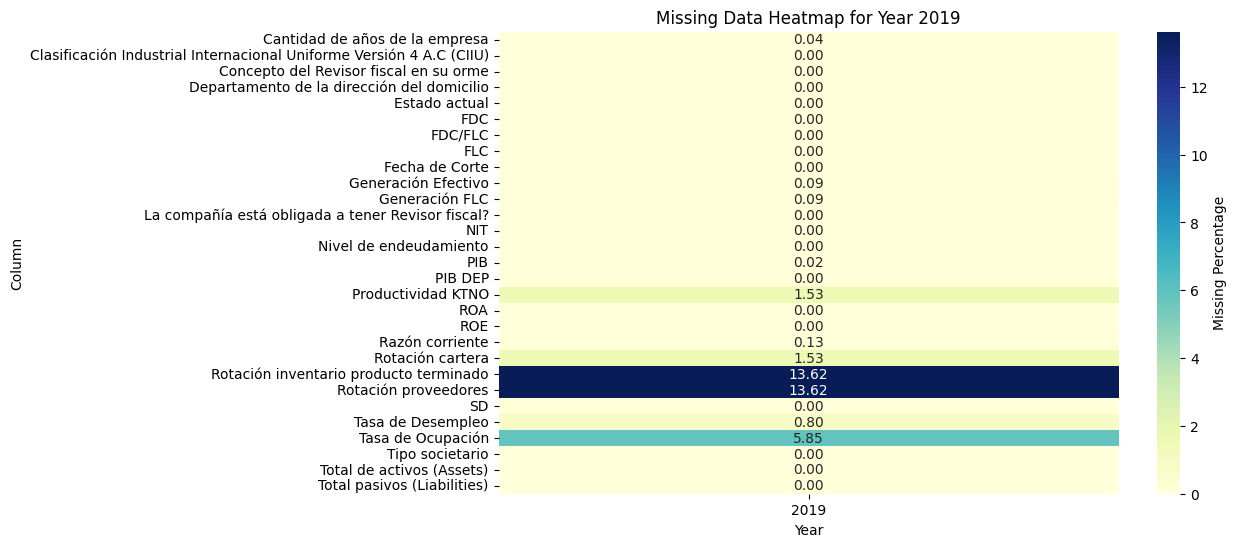

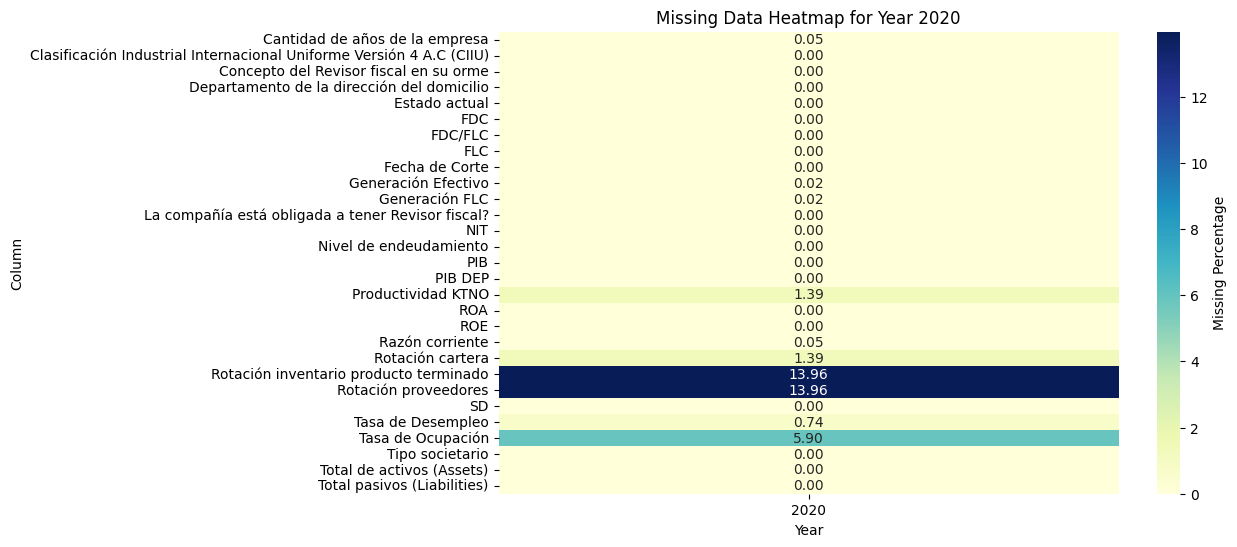

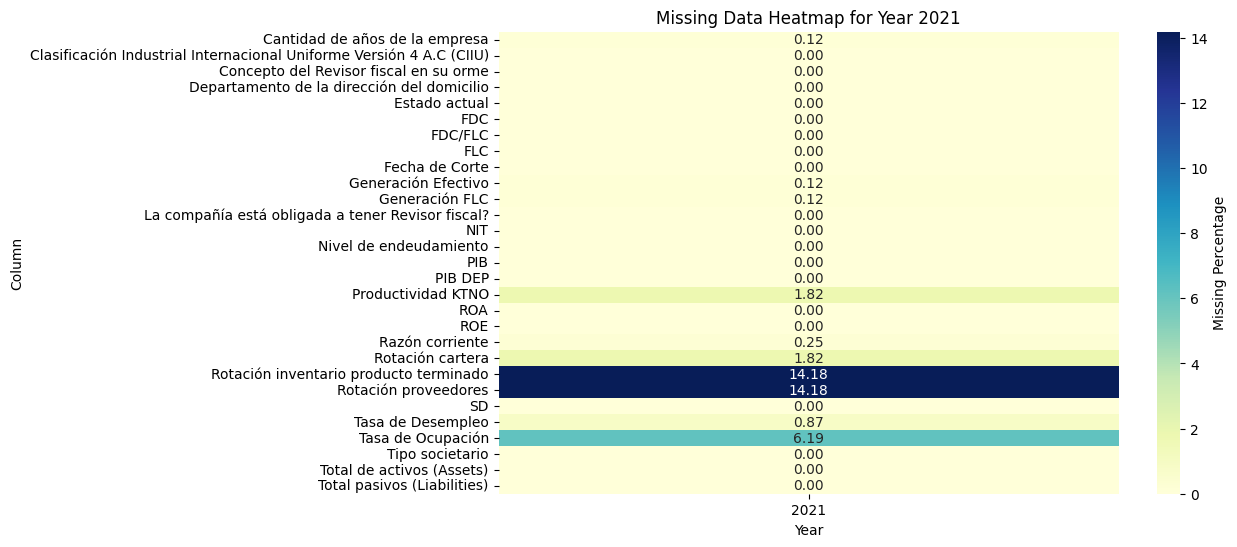

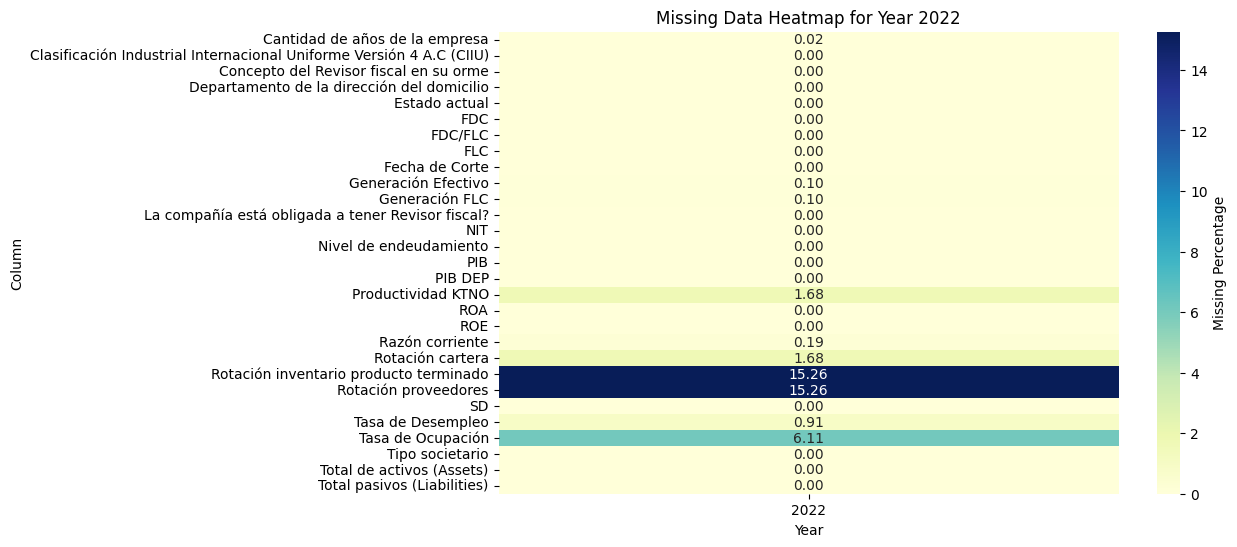

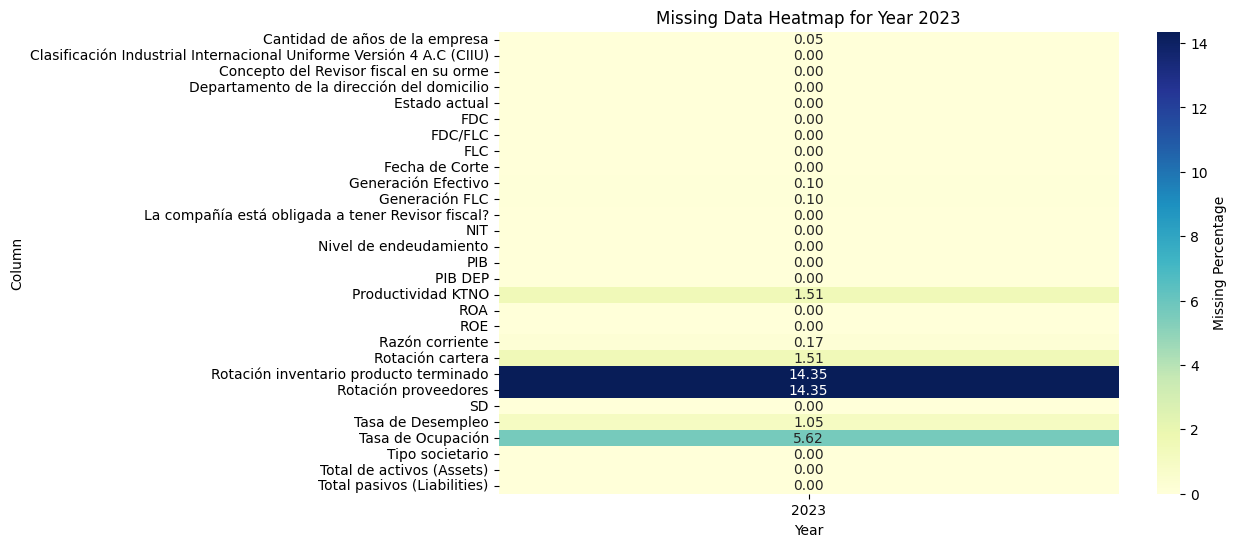

In [ ]:
def plot_missing_data_heatmap(missing_data_df):
    """Plots a heatmap of missing data for each year."""

    for year in missing_data_df['Year'].unique():
        year_data = missing_data_df[missing_data_df['Year'] == year]
        pivot_table = year_data.pivot(index='Column', columns='Year', values='Missing Percentage')

        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Missing Percentage'})
        plt.title(f"Missing Data Heatmap for Year {year}")
        plt.xlabel("Year")
        plt.ylabel("Column")
        plt.show()

plot_missing_data_heatmap(missing_data_df)

implementamos una función para generar un heatmap (mapa de calor) que muestra el porcentaje de datos faltantes por columna para cada año. Muestra los porcentajes de datos faltantes, creando una tabla adecuada para la representación gráfica mediante un heatmap

## Imputación de datos

Se realiza el proceso de imputación de datos para variables numéricas, por lo que se procede a analizar su distribución

In [ ]:
#Volver al NIT categorico
data['NIT'] = data['NIT'].astype(str)
numericos = data.select_dtypes(include = ['int64', 'float64'])
print(numericos.columns)

Index(['Cantidad de años de la empresa', 'Fecha de Corte',
       'Total de activos (Assets)', 'Total pasivos (Liabilities)',
       'Razón corriente', 'Rotación inventario producto terminado',
       'Rotación cartera', 'Rotación proveedores', 'Productividad KTNO', 'ROA',
       'ROE', 'Nivel de endeudamiento', 'Generación Efectivo', 'FLC',
       'FDC/FLC', 'SD', 'FDC', 'Generación FLC', 'Tasa de Desempleo',
       'Tasa de Ocupación', 'PIB', 'PIB DEP'],
      dtype='object')


El listado de columnas proporciona una visión detallada de las variables que componen el conjunto de datos.

In [ ]:
def normality_test_by_year(data):

    results = []
    numeric_cols = data.select_dtypes(include=['number']).columns

    for year in data['Fecha de Corte'].unique():
        year_data = data[data['Fecha de Corte'] == year]
        for col in numeric_cols:
            if len(year_data[col].dropna()) >= 3: # Shapiro-Wilk requires at least 3 data points
              statistic, p_value = stats.shapiro(year_data[col].dropna())
              results.append({
                  'Year': year,
                  'Variable': col,
                  'Statistic': statistic,
                  'P-value': p_value,
                  'Normal': p_value > 0.05
              })
            else:
              results.append({
                  'Year': year,
                  'Variable': col,
                  'Statistic': 'N/A',
                  'P-value': 'N/A',
                  'Normal': 'N/A'
              })

    return pd.DataFrame(results)

normality_results = normality_test_by_year(data)
print(tabulate(normality_results, headers='keys', tablefmt='grid'))

+-----+--------+----------------------------------------+-------------+--------------+----------+
|     |   Year | Variable                               |   Statistic |      P-value | Normal   |
+=====+========+========================================+=============+==============+==========+
|   0 |   2017 | Cantidad de años de la empresa         |  0.853403   | 3.137e-53    | False    |
+-----+--------+----------------------------------------+-------------+--------------+----------+
|   1 |   2017 | Fecha de Corte                         |  1          | 1            | True     |
+-----+--------+----------------------------------------+-------------+--------------+----------+
|   2 |   2017 | Total de activos (Assets)              |  0.451463   | 7.8831e-79   | False    |
+-----+--------+----------------------------------------+-------------+--------------+----------+
|   3 |   2017 | Total pasivos (Liabilities)            |  0.419361   | 4.76258e-80  | False    |
+-----+--------+----

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5276.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5278.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5271.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: 

El código realiza una prueba de normalidad Shapiro-Wilk para las variables numéricas del conjunto de datos, evaluando su distribución año a año. Los resultados muestran que la mayoría de las variables no siguen una distribución normal (p-valor < 0.05), excepto algunas excepciones como "Fecha de Corte". 

In [ ]:
missing_data_percentage = data.isnull().sum() / len(data) * 100
columns_to_impute_iteratively = missing_data_percentage[missing_data_percentage > 5].index

iterative_imputer = IterativeImputer(max_iter=10, random_state=0)

data_iteratively_imputed = data.copy()
data_iteratively_imputed[columns_to_impute_iteratively] = iterative_imputer.fit_transform(data[columns_to_impute_iteratively])

numeric_cols = data.select_dtypes(include=['number']).columns
numeric_imputer = SimpleImputer(strategy='median')

for col in numeric_cols:
    if col not in columns_to_impute_iteratively:
        data_iteratively_imputed[col] = numeric_imputer.fit_transform(data_iteratively_imputed[[col]])

categorical_cols = data.select_dtypes(include=['object', 'category']).columns
categorical_imputer = SimpleImputer(strategy='most_frequent')

for col in categorical_cols:
    data_iteratively_imputed[col] = categorical_imputer.fit_transform(data_iteratively_imputed[[col]]).ravel()

data_iteratively_imputed

Estado actual        NIT Concepto del Revisor fiscal en su orme  \
2             ACTIVA  800000313                             03. LIMPIO   
3             ACTIVA  800000439                             03. LIMPIO   
12            ACTIVA  800001354                             03. LIMPIO   
13            ACTIVA  800001650                             03. LIMPIO   
16            ACTIVA  800002143                             03. LIMPIO   
...              ...        ...                                    ...   
141588        ACTIVA  901507911                             03. LIMPIO   
141589        ACTIVA  901508416                             03. LIMPIO   
141602        ACTIVA  901543555                             03. LIMPIO   
141604        ACTIVA  901547742                             03. LIMPIO   
141612        ACTIVA  901626193                             03. LIMPIO   

       La compañía está obligada a tener Revisor fiscal?  \
2                                                     SI   
3                                                     SI   
12                                                    SI   
13                                                    SI   
16                                                    SI   
...                                                  ...   
141588                                                SI   
141589                                                SI   
141602                                                SI   
141604                                                SI   
141612                                                SI   

                                   Tipo societario  \
2       08. SOCIEDAD POR ACCIONES SIMPLIFICADA SAS   
3                            03. SOCIEDAD LIMITADA   
12                           03. SOCIEDAD LIMITADA   
13                            01. SOCIEDAD ANÓNIMA   
16                            01. SOCIEDAD ANÓNIMA   
...                                            ...   
141588  08. SOCIEDAD POR ACCIONES SIMPLIFICADA SAS   
141589  08. SOCIEDAD POR ACCIONES SIMPLIFICADA SAS   
141602  08. SOCIEDAD POR ACCIONES SIMPLIFICADA SAS   
141604  08. SOCIEDAD POR ACCIONES SIMPLIFICADA SAS   
141612  08. SOCIEDAD POR ACCIONES SIMPLIFICADA SAS   

        Cantidad de años de la empresa  \
2                                 30.0   
3                                 30.0   
12                                30.0   
13                                30.0   
16                                30.0   
...                                ...   
141588                             2.0   
141589                             2.0   
141602                             2.0   
141604                             2.0   
141612                             1.0   

       Departamento de la dirección del domicilio  Fecha de Corte  \
2                                     BOGOTA D.C.          2017.0   
3                                    CUNDINAMARCA          2017.0   
12                                          VALLE          2017.0   
13                                    BOGOTA D.C.          2017.0   
16                                    BOGOTA D.C.          2017.0   
...                                           ...             ...   
141588                                BOGOTA D.C.          2023.0   
141589                                BOGOTA D.C.          2023.0   
141602                                BOGOTA D.C.          2023.0   
141604                                  ATLANTICO          2023.0   
141612                                  SANTANDER          2023.0   

       Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)  \
2                              Industrias manufactureras.                     
3       Comercio al por mayor y al por menor; reparaci...                     
12      Agricultura, ganadería, caza, silvicultura y p...                     
13                             Industrias manufactureras.                     
16                 

Esta ya seria el dataset con los datos imputados

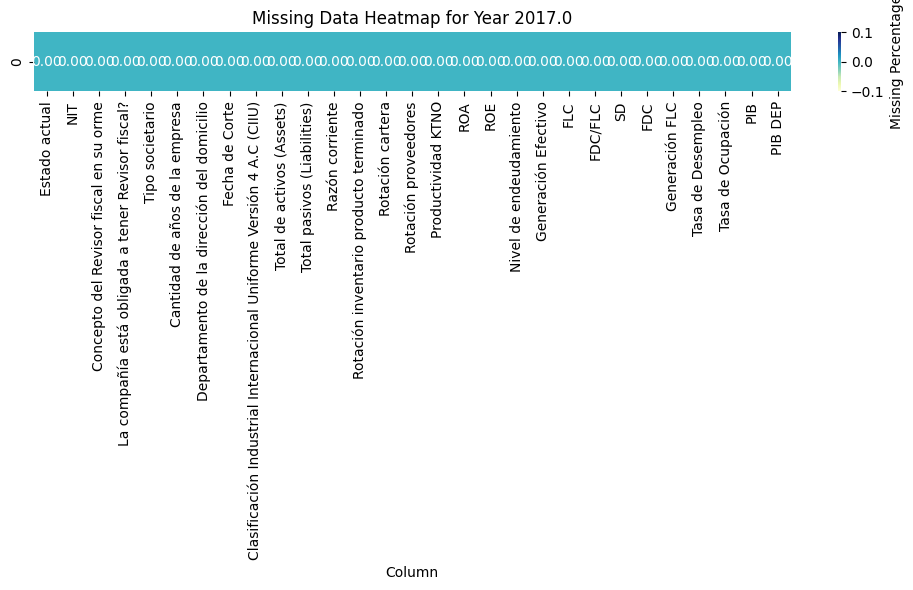

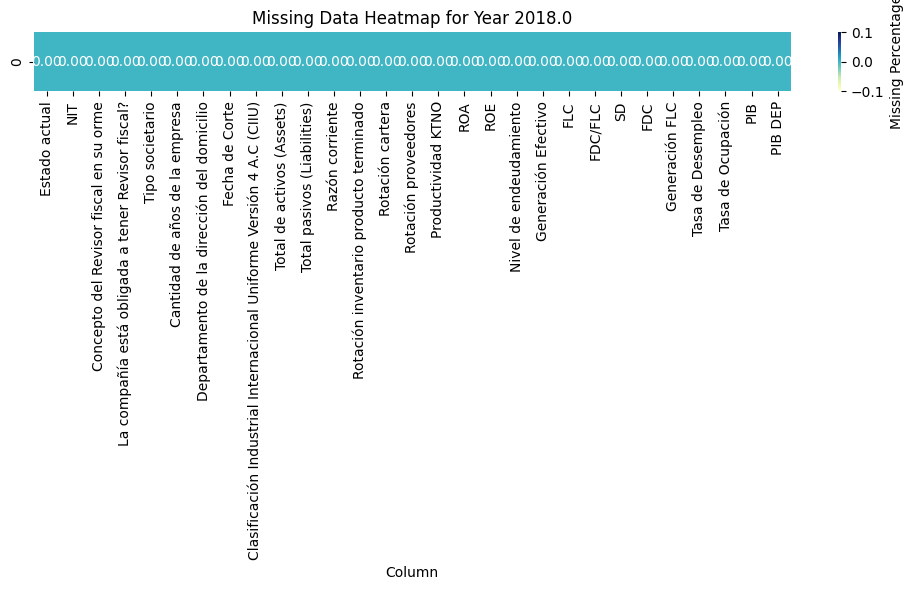

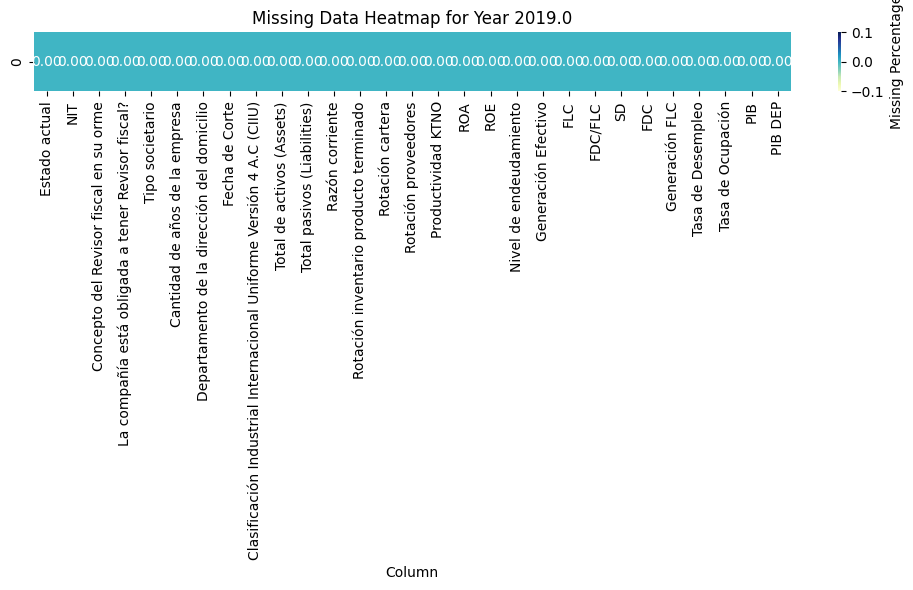

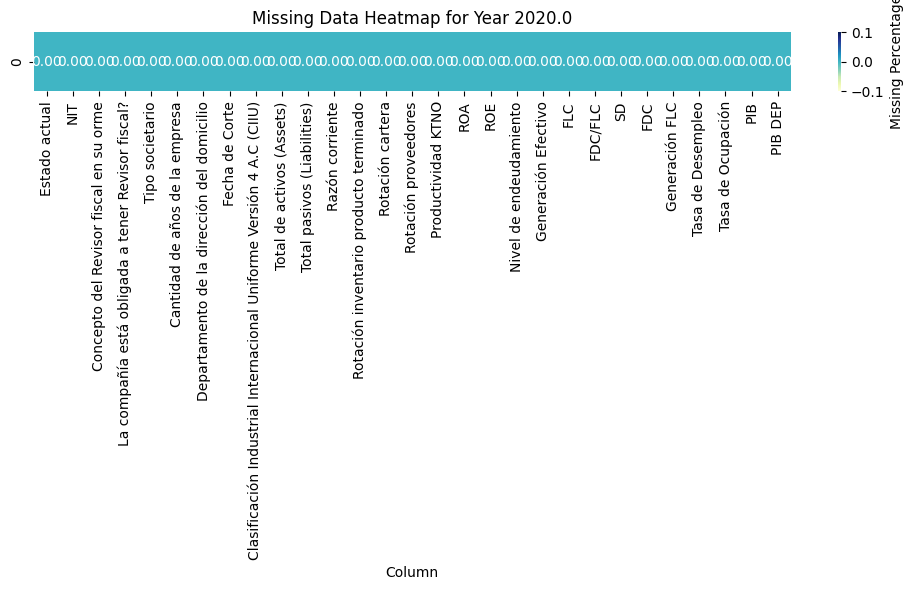

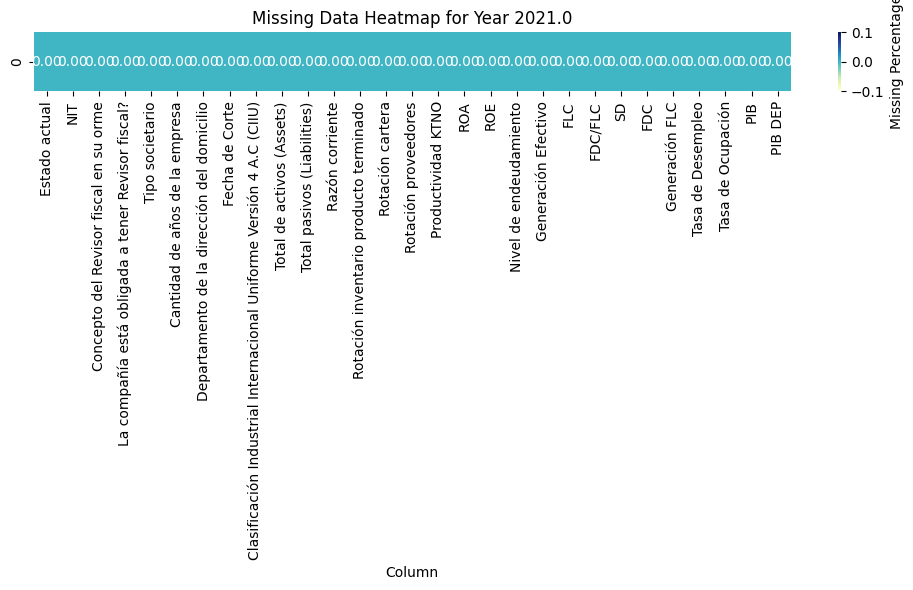

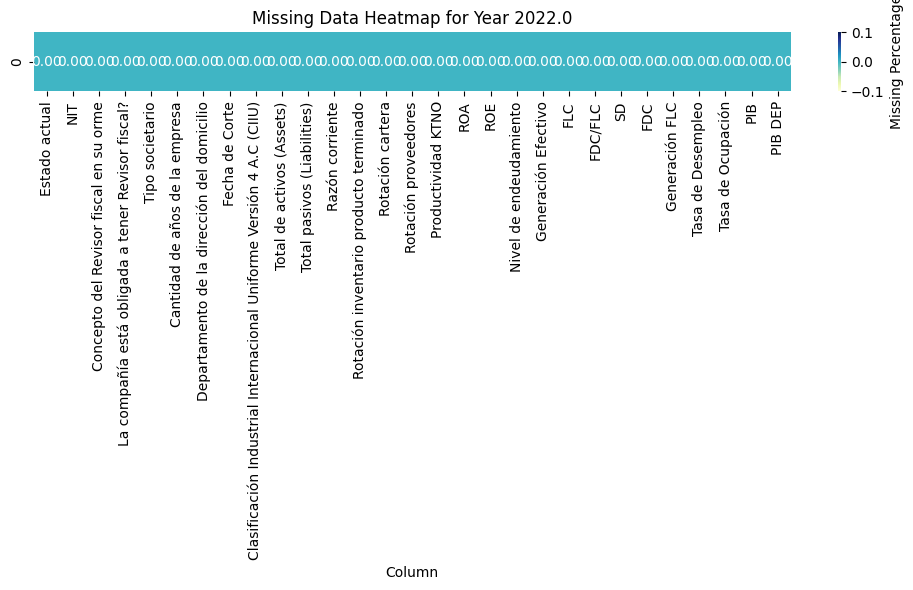

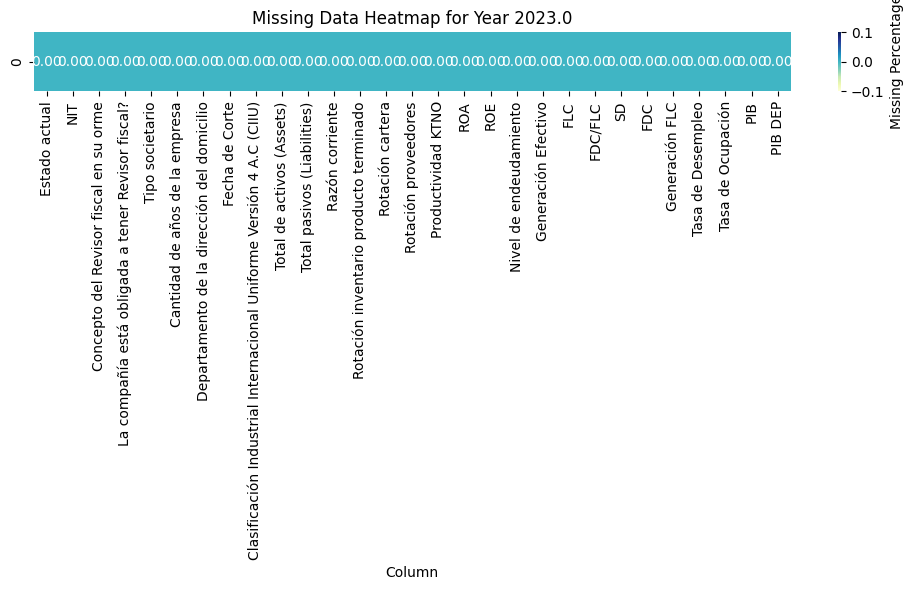

In [ ]:
def plot_missing_data_heatmap(data):
    """Plots a heatmap of missing data for each year."""

    for year in data['Fecha de Corte'].unique():
        year_data = data[data['Fecha de Corte'] == year]
        missing_percentage = year_data.isnull().sum() / len(year_data) * 100
        missing_percentage = missing_percentage.sort_values(ascending=False)

        plt.figure(figsize=(10, 6))
        sns.heatmap(pd.DataFrame(missing_percentage).T, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Missing Percentage'})
        plt.title(f"Missing Data Heatmap for Year {year}")
        plt.xlabel("Column")
        plt.ylabel("")  
        plt.xticks(rotation=90)  
        plt.tight_layout()
        plt.show()

plot_missing_data_heatmap(data_iteratively_imputed)

La función que genera mapas de calor iterativos para visualizar el porcentaje de datos faltantes en cada columna del conjunto de datos, año por año, basado en la variable Fecha de Corte. La función calcula el porcentaje de datos faltantes para cada columna, lo organiza de mayor a menor y genera un gráfico para cada año. Los gráficos proporcionan una visión clara de cómo varían los datos faltantes en las columnas a lo largo de los años. En el ejemplo mostrado, el porcentaje de datos faltantes para el año 2017 es prácticamente inexistente (0%), y asi para todos los años. Indicando que se imputaron todos los datos faltantes.

In [ ]:
def compare_distributions(original_data, imputed_data, column_name):
    statistic, p_value = ks_2samp(original_data[column_name].dropna(), imputed_data[column_name])
    return {"statistic": statistic, "p_value": p_value}

for col in numericos.columns: 
  comparison_results = compare_distributions(data, data_iteratively_imputed, col)
  print(f"Kolmogorov-Smirnov test for {col}:")
  print(f"  Statistic: {comparison_results['statistic']:.3f}")
  print(f"  P-value: {comparison_results['p_value']:.3f}")

  alpha = 0.05
  if comparison_results["p_value"] < alpha:
      print(f"  The distributions of {col} are significantly different after imputation.")
  else:
      print(f"  The distributions of {col} are not significantly different after imputation.")
  print("---")

Kolmogorov-Smirnov test for Cantidad de años de la empresa:
  Statistic: 0.000
  P-value: 1.000
  The distributions of Cantidad de años de la empresa are not significantly different after imputation.
---
Kolmogorov-Smirnov test for Fecha de Corte:
  Statistic: 0.000
  P-value: 1.000
  The distributions of Fecha de Corte are not significantly different after imputation.
---
Kolmogorov-Smirnov test for Total de activos (Assets):
  Statistic: 0.000
  P-value: 1.000
  The distributions of Total de activos (Assets) are not significantly different after imputation.
---
Kolmogorov-Smirnov test for Total pasivos (Liabilities):
  Statistic: 0.000
  P-value: 1.000
  The distributions of Total pasivos (Liabilities) are not significantly different after imputation.
---
Kolmogorov-Smirnov test for Razón corriente:
  Statistic: 0.001
  P-value: 1.000
  The distributions of Razón corriente are not significantly different after imputation.
---
Kolmogorov-Smirnov test for Rotación inventario producto t

El código utiliza la prueba de Kolmogorov-Smirnov para comparar las distribuciones de las variables numéricas antes y después de la imputación de datos faltantes, verificando si esta alteró significativamente su estructura estadística. La prueba evalúa la diferencia entre las distribuciones mediante un estadístico y un p-valor, donde un p-valor mayor a 0.05 indica que las distribuciones originales e imputadas no son significativamente diferentes.

### Verificar VIF

In [ ]:
numeric_vars = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [ ]:
exclude_vars = ['NIT', 'Fecha de Corte', 'FDC_FLC_categoria', 'FDC_FLC_categoria_code']
numeric_vars = [var for var in numeric_vars if var not in exclude_vars]


In [ ]:
def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    X = df[features].dropna()
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                       for i in range(len(features))]
    return vif_data

features = numeric_vars.copy()
iteration = 1

while True:
    print(f"\nIteración {iteration}")
    vif_df = calculate_vif(data, features)
    print(vif_df)

    if vif_df['VIF'].max() <= 10:
        print("\nNo hay variables con VIF > 10. Se detiene la iteración.")
        break
    else:
        max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Variable']
        max_vif_value = vif_df['VIF'].max()
        print(f"Eliminando variable '{max_vif_feature}' con VIF = {max_vif_value}")
        features.remove(max_vif_feature)
        iteration += 1

print("\nConjunto final de variables después de eliminar multicolinealidad:")
print(features)


Iteración 1


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                  Variable           VIF
0           Cantidad de años de la empresa  3.310142e+00
1                Total de activos (Assets)  8.219144e+00
2              Total pasivos (Liabilities)  7.026376e+00
3                          Razón corriente  1.001332e+00
4   Rotación inventario producto terminado  9.198095e+03
5                         Rotación cartera  1.729316e+03
6                     Rotación proveedores  1.973792e+02
7                       Productividad KTNO  1.491872e+04
8                                      ROA  1.685206e+00
9                                      ROE  1.000548e+00
10                  Nivel de endeudamiento  3.696967e+00
11                     Generación Efectivo  1.486128e+01
12                                     FLC           inf
13                                 FDC/FLC  1.000306e+00
14                                      SD           inf
15                                     FDC           inf
16                          Gen

Factor de Inflación de la Varianza (VIF) y eliminar variables con alta multicolinealidad (VIF > 10), asegurando un conjunto de características más independientes y adecuadas para el modelado. El VIF evalúa cuánto aumenta la varianza de un coeficiente de regresión debido a la multicolinealidad; valores altos indican redundancia entre variables. En este caso, se identificaron y eliminaron variables como "FLC" debido a su colinealidad perfecta (VIF infinito).

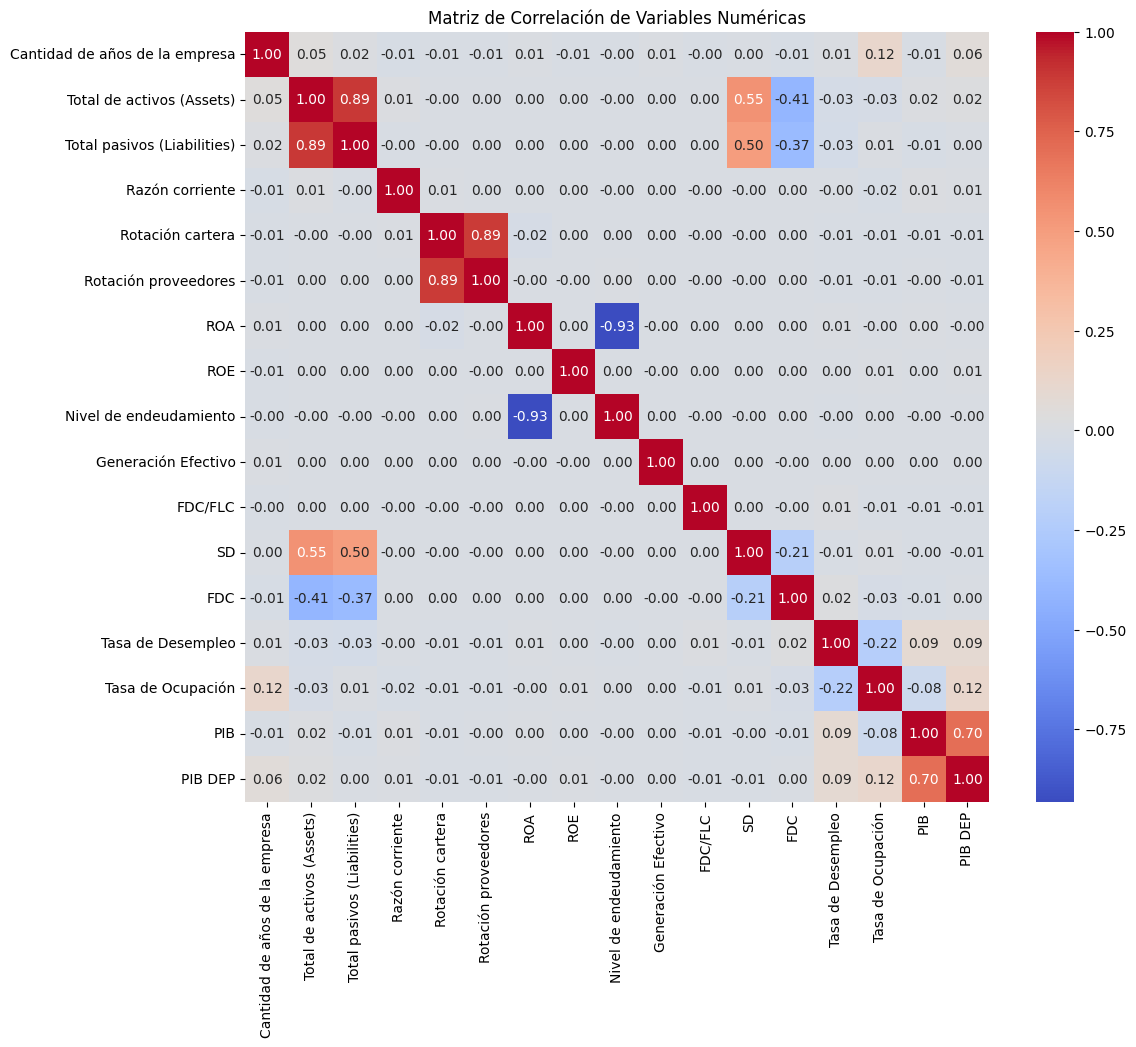

In [ ]:
# Seleccionar solo las variables numéricas
numeric_df = data[features]

# Calcular la matriz de correlación
corr_matrix = numeric_df.corr()

# Plotear la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

Generamos una matriz de correlación para las variables numéricas, representada mediante un mapa de calor, lo que permite identificar relaciones lineales entre variables. La matriz revela correlaciones fuertes, como la positiva entre "Total de activos (Assets)" y "Total pasivos (Liabilities)" (0.89), lo que indica que estas variables están altamente relacionadas. También se observa una correlación negativa significativa entre "ROE" y "Nivel de endeudamiento" (-0.93), reflejando la influencia del apalancamiento sobre la rentabilidad. Este análisis es clave para detectar colinealidad y redundancia entre las variables.

# Modelamiento

Observar las variables restantes

In [ ]:
variables_to_keep = [
    'Cantidad de años de la empresa',
    'Total de activos (Assets)',
    'Total pasivos (Liabilities)',
    'Razón corriente',
    'Rotación cartera',
    'Rotación proveedores',
    'ROA',
    'ROE',
    'Nivel de endeudamiento',
    'Generación Efectivo',
    'FDC/FLC',
    'SD',
    'FDC',
    'Tasa de Desempleo',
    'Tasa de Ocupación',
    'PIB',
    'PIB DEP',
    'NIT',
    'FDC_FLC_categoria'
]

# Filtrar variables seleccionadas y categóricas
filtered_data = data[variables_to_keep + data.select_dtypes(include=['object', 'category']).columns.tolist()]
data = filtered_data.copy()
data = data.loc[:, ~data.columns.duplicated()]


In [ ]:
print(data.columns.tolist())

['Cantidad de años de la empresa', 'Fecha de Corte', 'Total de activos (Assets)', 'Total pasivos (Liabilities)', 'Razón corriente', 'Rotación cartera', 'Rotación proveedores', 'ROA', 'ROE', 'Nivel de endeudamiento', 'Generación Efectivo', 'FDC/FLC', 'SD', 'FDC', 'Tasa de Desempleo', 'Tasa de Ocupación', 'PIB', 'PIB DEP', 'NIT', 'FDC_FLC_categoria', 'Estado actual', 'Concepto del Revisor fiscal en su orme', 'La compañía está obligada a tener Revisor fiscal?', 'Tipo societario', 'Departamento de la dirección del domicilio', 'Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)']


Listar los nombres de las columnas presentes en el conjunto de datos después de aplicar el filtrado.

In [ ]:
variabletypes = data.dtypes.value_counts().reset_index()
variabletypes.columns = ['Data Type', 'Count']

variabletypes

Data Type  Count
0   float64     17
1    object      7
2     int64      1
3  category      1

Resumen de los tipos de datos presentes en el conjunto de datos filtrado, indicando que contiene 17 variables numéricas de tipo float64, 7 variables categóricas de tipo object, 1 variable de tipo entero (int64) y 1 variable categórica (category).

## Modelo de regresión logística Multinomial

**Supuestos:**

La regresión logística multinomial tiene varios supuestos:

- `Independencia de las observaciones:` Las observaciones deben ser independientes entre sí.
- `No multicolinealidad:` Las variables independientes no deben estar altamente correlacionadas.
- `Linealidad en el logit:` Relación lineal entre las variables independientes continuas y el logit de la variable dependiente.
- `Independencia de alternativas irrelevantes (IIA):` La elección entre dos categorías no debe verse afectada por la introducción o eliminación de otras categorías.

En datos de panel, el supuesto de independencia de las observaciones se viola porque tenemos múltiples observaciones para cada empresa a lo largo del tiempo. Esto introduce correlación intra-grupo.

**Preparación de los datos**

In [ ]:

numeric_vars = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

category_vars = data.select_dtypes(include=['category']).columns.tolist()

object_vars = data.select_dtypes(include=['object']).columns.tolist()
categorical_vars = category_vars + object_vars

print("Variables numéricas:", numeric_vars)
print("Variables categóricas:", categorical_vars)

Variables numéricas: ['Cantidad de años de la empresa', 'Fecha de Corte', 'Total de activos (Assets)', 'Total pasivos (Liabilities)', 'Razón corriente', 'Rotación cartera', 'Rotación proveedores', 'ROA', 'ROE', 'Nivel de endeudamiento', 'Generación Efectivo', 'FDC/FLC', 'SD', 'FDC', 'Tasa de Desempleo', 'Tasa de Ocupación', 'PIB', 'PIB DEP']
Variables categóricas: ['FDC_FLC_categoria', 'NIT', 'Estado actual', 'Concepto del Revisor fiscal en su orme', 'La compañía está obligada a tener Revisor fiscal?', 'Tipo societario', 'Departamento de la dirección del domicilio', 'Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)']


In [ ]:
print("Años disponibles en el dataset:", data['Fecha de Corte'].unique())

Años disponibles en el dataset: [2017 2018 2019 2020 2021 2022 2023]


In [ ]:
# Codificar la variable objetivo
data['FDC_FLC_categoria_code'] = data['FDC_FLC_categoria'].cat.codes

El código transforma la variable categórica 'FDC_FLC_categoria' en una variable numérica denominada 'FDC_FLC_categoria_code', asignando códigos enteros únicos a cada categoría mediante .cat.codes. 

In [ ]:
# Excluir variables no necesarias
exclude_vars = ['FDC_FLC_categoria', 'FDC_FLC_categoria_code', 'NIT', 'Fecha de Corte', 'FDC/FLC']

# Variables numéricas finales para el modelo
model_numeric_vars = [var for var in numeric_vars if var not in exclude_vars]

# Variables categóricas finales para el modelo
model_categorical_vars = [var for var in categorical_vars if var not in exclude_vars]

El código filtra las variables finales para el modelo excluyendo aquellas no relevantes, como `FDC_FLC_categoria` y su versión codificada (`FDC_FLC_categoria_code`), `NIT`, `Fecha de Corte` y `FDC/FLC`, que no aportan valor predictivo o introducen redundancias.

In [ ]:
print("Variables numéricas utilizadas en el modelo:", model_numeric_vars)
print("Variables categóricas utilizadas en el modelo:", model_categorical_vars)


Variables numéricas utilizadas en el modelo: ['Cantidad de años de la empresa', 'Total de activos (Assets)', 'Total pasivos (Liabilities)', 'Razón corriente', 'Rotación cartera', 'Rotación proveedores', 'ROA', 'ROE', 'Nivel de endeudamiento', 'Generación Efectivo', 'SD', 'FDC', 'Tasa de Desempleo', 'Tasa de Ocupación', 'PIB', 'PIB DEP']
Variables categóricas utilizadas en el modelo: ['Estado actual', 'Concepto del Revisor fiscal en su orme', 'La compañía está obligada a tener Revisor fiscal?', 'Tipo societario', 'Departamento de la dirección del domicilio', 'Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)']


In [ ]:
available_years = data['Fecha de Corte'].unique()
time_series_splits = []

for i in range(1, len(available_years)):
    train_years = available_years[:i] 
    test_years = [available_years[i]]  
    train_indices = data[data['Fecha de Corte'].isin(train_years)].index
    test_indices = data[data['Fecha de Corte'].isin(test_years)].index
    time_series_splits.append((train_indices, test_indices))


train_years = [year for year in train_years if year in available_years]
test_years = [year for year in test_years if year in available_years]


In [ ]:
# Dividir los datos
train_data = data[data['Fecha de Corte'].isin(train_years)]
test_data = data[data['Fecha de Corte'].isin(test_years)]

# Verificar el número de muestras
print("Número de muestras en el conjunto de entrenamiento:", train_data.shape[0])
print("Número de muestras en el conjunto de prueba:", test_data.shape[0])

Número de muestras en el conjunto de entrenamiento: 19545
Número de muestras en el conjunto de prueba: 17623


La division división para series temporales, creando conjuntos de entrenamiento y prueba basados en la variable `Fecha de Corte`. El conjunto de entrenamiento incluye los datos de años anteriores al año actual de prueba, mientras que el conjunto de prueba contiene los datos del año seleccionado, respetando la secuencia temporal. Este enfoque evita la contaminación del conjunto de entrenamiento con datos futuros, garantizando evaluaciones más realistas y alineadas con escenarios reales. Además, se verifica el número de muestras en cada conjunto para confirmar que la división se realizó correctamente, preservando la integridad del análisis.

In [ ]:
# Variables predictoras
model_vars = model_numeric_vars + model_categorical_vars

x= train_data[model_vars]
y = train_data['FDC_FLC_categoria_code']

In [ ]:
# Verificar valores nulos en X_train
print("Valores nulos en X_train:\n", x.isnull().sum())

Valores nulos en X_train:
 Cantidad de años de la empresa                                          0
Total de activos (Assets)                                               0
Total pasivos (Liabilities)                                             0
Razón corriente                                                         0
Rotación cartera                                                        0
Rotación proveedores                                                    0
ROA                                                                     0
ROE                                                                     0
Nivel de endeudamiento                                                  0
Generación Efectivo                                                     0
SD                                                                      0
FDC                                                                     0
Tasa de Desempleo                                                       0
Tasa de Ocu

El código verifica la existencia de valores nulos en el conjunto de entrenamiento (`X_train`) después de seleccionar las variables numéricas y categóricas relevantes para el modelo. La salida confirma que no existen valores nulos en ninguna de las variables incluidas en `X_train`.

 Al asegurar que no hay datos faltantes, se confirma que el preprocesamiento y las imputaciones previas se realizaron correctamente. Esto permite avanzar hacia el entrenamiento del modelo con la confianza de que las entradas están completas y listas para ser procesadas.

In [ ]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, model_numeric_vars),
        ('cat', categorical_transformer, model_categorical_vars)
    ])

pipeline_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

In [ ]:

for train_idx, test_idx in time_series_splits:
    X_train, X_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    pipeline_logreg.fit(X_train, y_train)
    y_pred_logreg = pipeline_logreg.predict(X_test)

print("\nReporte de clasificación en el conjunto de prueba (Regresión Logística Multinomial):")
print(classification_report(y_test, y_pred_logreg))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.




Reporte de clasificación en el conjunto de prueba (Regresión Logística Multinomial):
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      3652
           1       0.60      0.87      0.71      3236
           2       0.12      0.00      0.00       762
           3       0.76      0.48      0.58      1984
           4       0.83      0.91      0.87      4489

    accuracy                           0.75     14123
   macro avg       0.63      0.60      0.59     14123
weighted avg       0.73      0.75      0.72     14123



Ahora el preprocesamiento de datos y el entrenamiento de un modelo de Regresión Logística Multinomial, utilizando divisiones temporales para entrenar y probar el modelo. El preprocesamiento incluye la estandarización de variables numéricas y la codificación de variables categóricas, asegurando un flujo de datos adecuado. Los resultados muestran un desempeño general con una precisión (accuracy) del 75% en el conjunto de prueba, destacándose un buen rendimiento en las clases `0` y `4`, pero con un desempeño muy bajo en la clase `2` (F1-score de 0.00), indicando dificultades para distinguir esta categoría. Esto sugiere la necesidad de ajustes adicionales, como técnicas de balanceo o ajustes de hiperparámetros, para mejorar la clasificación en las clases menos representadas.

In [ ]:
label_mapping = dict(enumerate(data['FDC_FLC_categoria'].cat.categories))

print("Mapa de etiquetas numéricas a categorías originales:")
for code, category in label_mapping.items():
    print(f"Etiqueta {code}: {category}")

Mapa de etiquetas numéricas a categorías originales:
Etiqueta 0: <0
Etiqueta 1: [0, 0.67)
Etiqueta 2: [0.67, 0.80)
Etiqueta 3: [0.80, 1)
Etiqueta 4: [1, ∞)


El mapeo entre etiquetas numéricas y categorías originales proporciona una interpretación clara de los resultados del modelo al asociar las predicciones numéricas con rangos específicos de la variable categórica `FDC_FLC_categoria`. Por ejemplo, la etiqueta `0` representa valores menores a `0`, mientras que las etiquetas restantes corresponden a rangos definidos, como `[0, 0.67)` o `[1, ∞)`. 

In [ ]:
# Matriz de confusión
print("Matriz de confusión (Regresión Logística Multinomial):")
print(confusion_matrix(y_test, y_pred_logreg))

Matriz de confusión (Regresión Logística Multinomial):
[[2693  257    0    6  696]
 [ 177 2822    7  108  122]
 [   4  553    1  191   13]
 [  14 1013    0  944   13]
 [ 395   25    0    0 4069]]


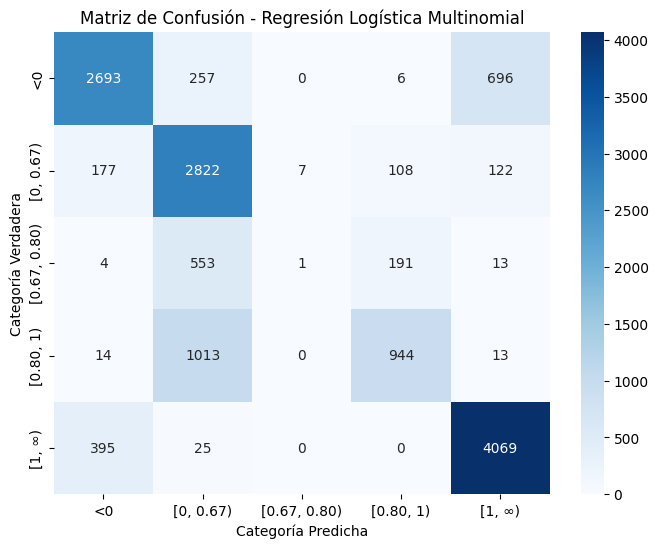

In [ ]:
cm = confusion_matrix(y_test, y_pred_logreg)

category_names = [label_mapping[i] for i in range(len(label_mapping))]

cm_df = pd.DataFrame(cm, index=category_names, columns=category_names)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística Multinomial')
plt.ylabel('Categoría Verdadera')
plt.xlabel('Categoría Predicha')
plt.show()

La matriz de confusión ilustra el desempeño del modelo de Regresión Logística Multinomial, destacando un buen rendimiento en categorías como `<0` y `[1, ∞)` con altos valores en la diagonal principal (2693 y 4069 predicciones correctas, respectivamente). Sin embargo, se observan errores significativos en categorías intermedias como `[0.67, 0.80)`, donde muchas observaciones son clasificadas erróneamente como categorías adyacentes, como `[0, 0.67)` o `[0.80, 1)`. Esto refleja que el modelo tiene dificultades para diferenciar límites entre estas clases, lo que sugiere la necesidad de ajustes adicionales, como balanceo de clases o una selección más precisa de características, para mejorar la clasificación en estas categorías específicas.

Curvas de ROC

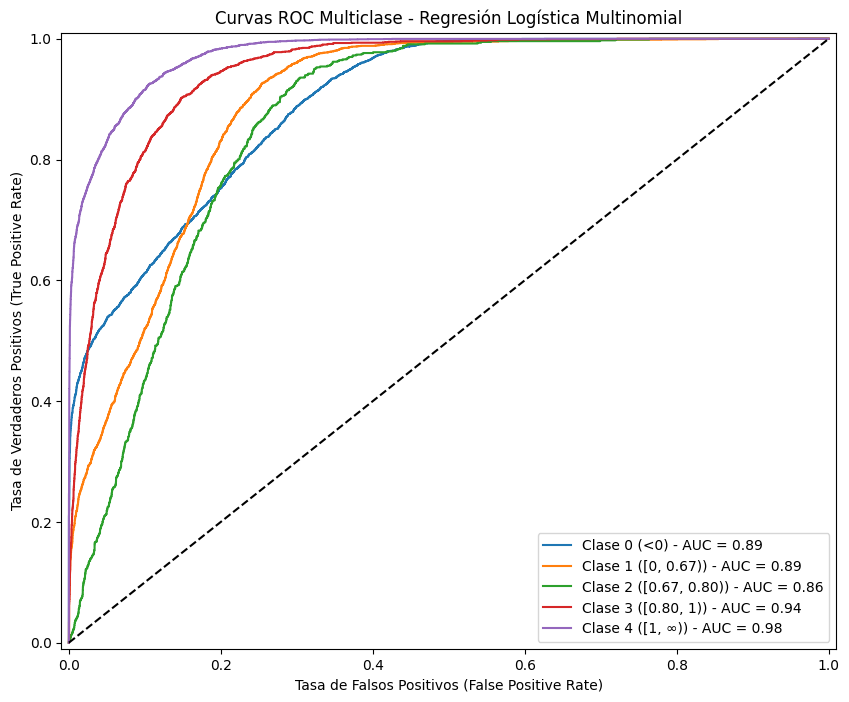

In [ ]:
# Binarizar las etiquetas de las clases para ROC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_binarized.shape[1]

# Obtener las probabilidades predichas
y_score = pipeline_logreg.predict_proba(X_test)

# Calcular la curva ROC y el área bajo la curva para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar las curvas ROC para cada clase
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} ({label_mapping[i]}) - AUC = {roc_auc[i]:0.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Tasa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Tasa de Verdaderos Positivos (True Positive Rate)')
plt.title('Curvas ROC Multiclase - Regresión Logística Multinomial')
plt.legend(loc='lower right')
plt.show()

La gráfica de las curvas ROC multiclase evalúa el desempeño del modelo de Regresión Logística Multinomial al clasificar las diferentes categorías. Cada curva representa la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para una clase específica, con su respectivo área bajo la curva (AUC).

Las clases muestran áreas bajo la curva (AUC) que oscilan entre 0.86 y 0.98, destacando un buen desempeño general del modelo. La clase `[1, ∞)` tiene la mayor AUC (0.98), indicando una excelente capacidad del modelo para distinguir esta categoría. En contraste, la clase `[0.67, 0.80)` tiene la AUC más baja (0.86), lo que coincide con los resultados previos que mostraron dificultades para clasificar esta categoría. Las AUC cercanas a 1 reflejan un modelo robusto en la mayoría de las clases.

La visualización de las curvas ROC multiclase permite evaluar la efectividad del modelo para cada clase, mostrando un desempeño sólido en general, pero con oportunidades de mejora en categorías específicas como `[0.67, 0.80)`. Este análisis reafirma la necesidad de ajustar el modelo para optimizar la discriminación en las clases con menor AUC.

Examinar coeficiente

In [ ]:
coefficients = pipeline_logreg.named_steps['classifier'].coef_

feature_names = pipeline_logreg.named_steps['preprocessor'].get_feature_names_out()

coef_df = pd.DataFrame(coefficients, columns=feature_names)

coef_df['Clase'] = pipeline_logreg.named_steps['classifier'].classes_

coef_df = coef_df.set_index('Clase')

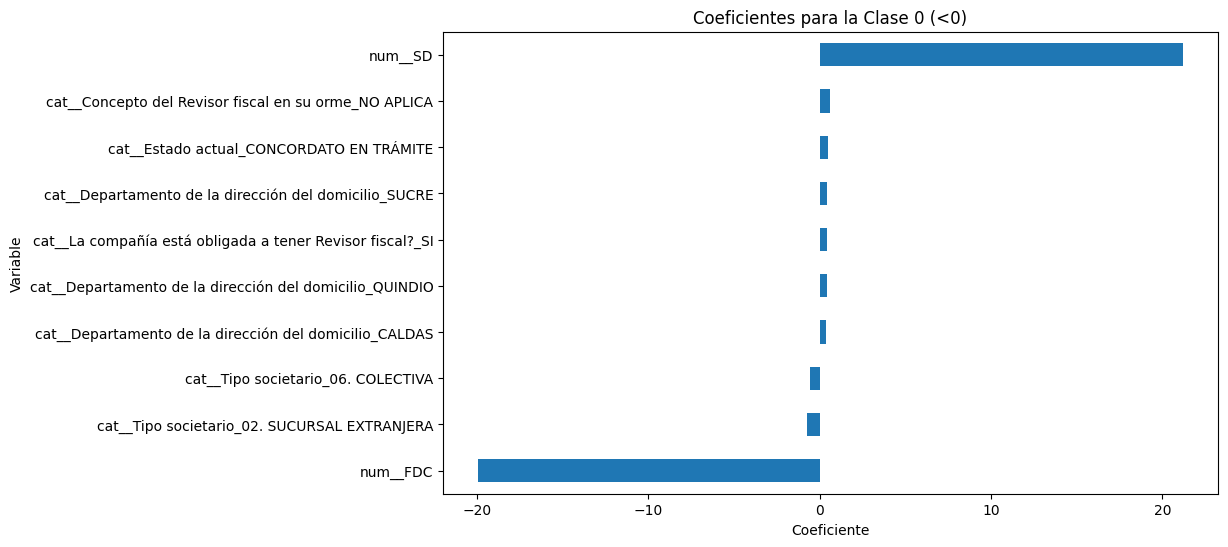

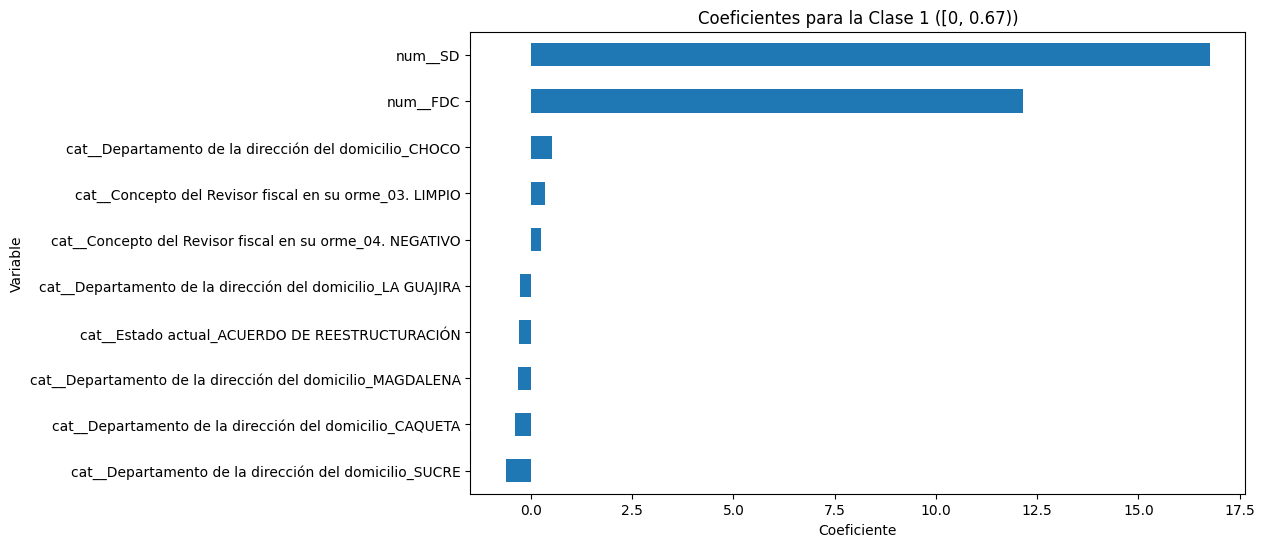

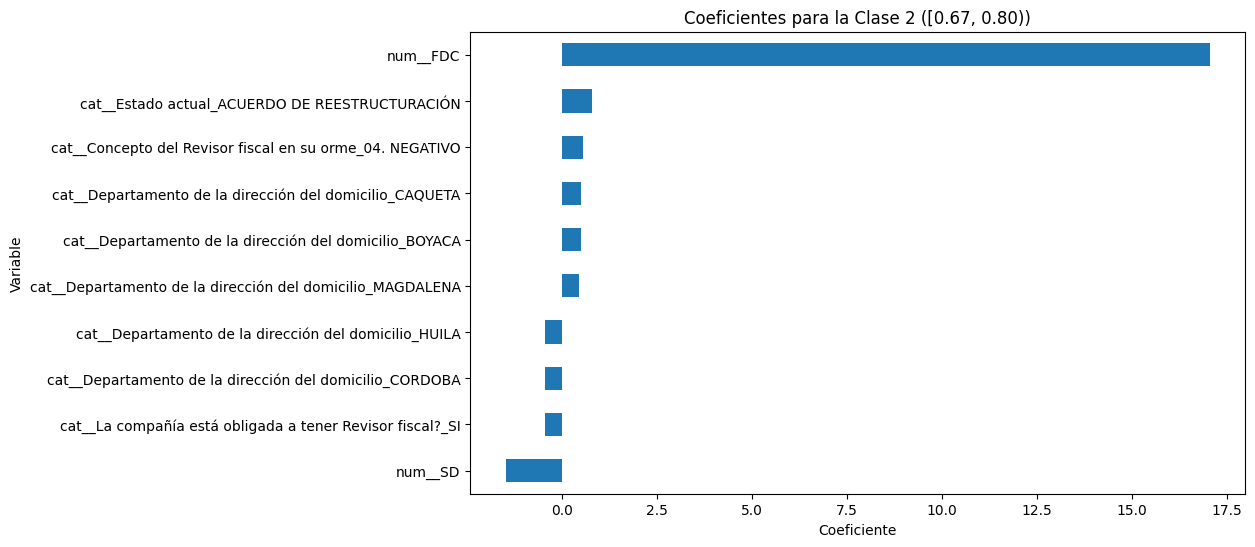

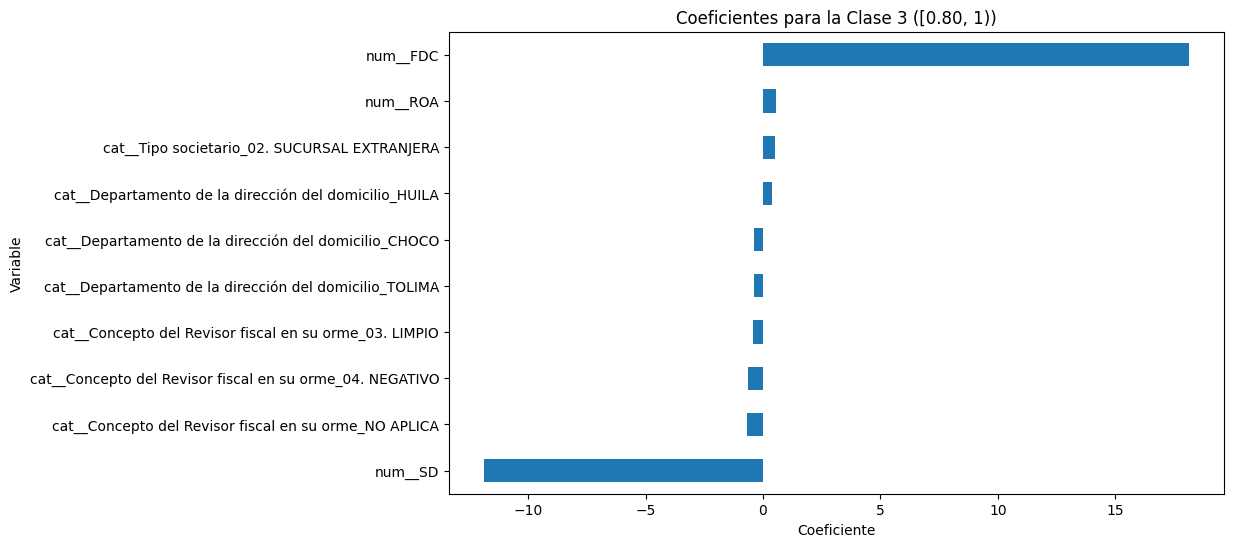

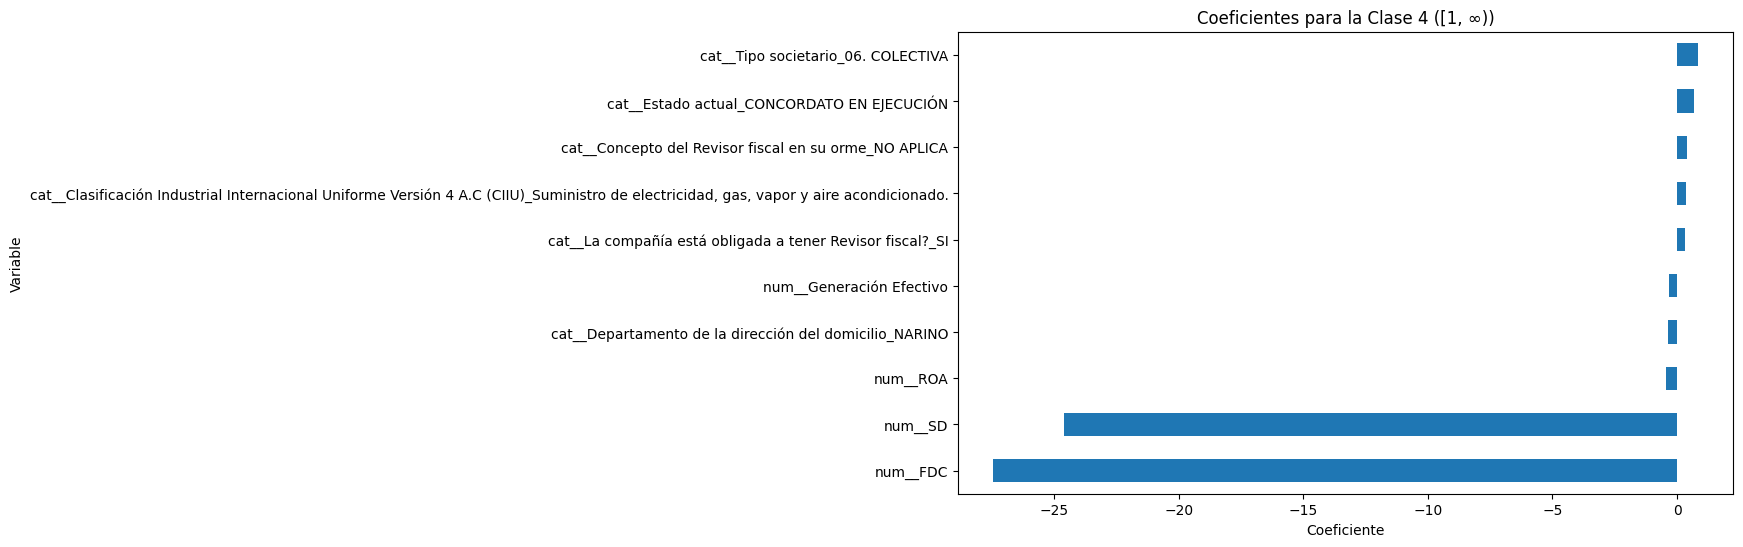

In [ ]:
# Seleccionar las variables más importantes (por ejemplo, las 10 con mayor coeficiente absoluto)
for clase in coef_df.index:
    # Obtener los coeficientes absolutos y ordenar
    coef_clase = coef_df.loc[clase].abs().sort_values(ascending=False)

    # Seleccionar las top 10 variables
    top_features = coef_clase.head(10).index
    top_coef = coef_df.loc[clase, top_features]

    # Plotear
    plt.figure(figsize=(10, 6))
    top_coef.sort_values().plot(kind='barh')
    plt.title(f'Coeficientes para la Clase {clase} ({label_mapping[clase]})')
    plt.xlabel('Coeficiente')
    plt.ylabel('Variable')
    plt.show()

Las gráficas de coeficientes destacan las 10 variables más influyentes en el modelo de Regresión Logística Multinomial para cada clase, mostrando cómo contribuyen a la probabilidad de clasificación. Variables numéricas como `num__SD` (Servicio de Deuda) y `num__FDC` (Flujo de Caja Directo) son particularmente relevantes en múltiples clases, reflejando su importancia en el desempeño financiero. Además, variables categóricas como `cat__Departamento de la dirección del domicilio` y `cat__Estado actual` tienen un impacto significativo en clases específicas, indicando posibles diferencias regionales o de estatus jurídico. Estas visualizaciones facilitan la interpretación del modelo y proporcionan insights clave sobre los factores determinantes para cada categoría.

### Modelo de regresión logistica multinomial generalizado

In [ ]:
data = data[data['SD'] > 0].copy()

data['Fecha de Corte'] = data['Fecha de Corte'].astype(int)

In [ ]:
bins = [-np.inf, 0, 0.67, 0.80, 1, np.inf]
labels = ['<0', '[0, 0.67)', '[0.67, 0.80)', '[0.80, 1)', '[1, ∞)']
data['FDC_FLC_categoria'] = pd.cut(data['FDC/FLC'], bins=bins, labels=labels, right=False)

categorical_vars = [
    'Estado actual',
    'Concepto del Revisor fiscal en su orme',
    'La compañía está obligada a tener Revisor fiscal?',
    'Tipo societario',
    'Departamento de la dirección del domicilio',
    'Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)'
]
for var in categorical_vars + ['FDC_FLC_categoria']:
    data[var] = data[var].astype('category')

data['FDC_FLC_categoria_code'] = data['FDC_FLC_categoria'].cat.codes

In [ ]:
labels = ['<0', '[0, 0.67)', '[0.67, 0.80)', '[0.80, 1)', '[1, ∞)']
label_mapping = {i: label for i, label in enumerate(labels)}

In [ ]:
model_numeric_vars = [
    'Cantidad de años de la empresa',
    'Total de activos (Assets)',
    'Total pasivos (Liabilities)',
    'Razón corriente',
    'Rotación cartera',
    'Rotación proveedores',
    'ROA',
    'ROE',
    'Nivel de endeudamiento',
    'Generación Efectivo',
    'SD',
    'FDC',
    'Tasa de Desempleo',
    'Tasa de Ocupación',
    'PIB',
    'PIB DEP'
]

model_vars = model_numeric_vars + model_categorical_vars

available_years = data['Fecha de Corte'].unique()
train_years = [year for year in train_years if year in available_years]
test_years = [year for year in test_years if year in available_years]


In [ ]:

# Eliminar filas con NaN en las variables seleccionadas
train_data = train_data.dropna(subset=model_vars + ['FDC_FLC_categoria_code'])
test_data = test_data.dropna(subset=model_vars + ['FDC_FLC_categoria_code'])

In [ ]:
# Calcular la matriz de correlación
corr_matrix = train_data[model_numeric_vars].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encontrar pares con correlación mayor a 0.8
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.8)]

print("Variables a eliminar por alta correlación:", to_drop_corr)

Variables a eliminar por alta correlación: ['Total pasivos (Liabilities)', 'Rotación proveedores']


In [ ]:
# Eliminar las variables altamente correlacionadas
model_numeric_vars = [var for var in model_numeric_vars if var not in to_drop_corr]
model_vars = model_numeric_vars + model_categorical_vars

El código realiza un preprocesamiento exhaustivo de los datos para garantizar su calidad y adecuación al modelado. Se filtran registros con `SD` (Servicio de Deuda) mayores a 0, se clasifica la variable `FDC/FLC` en rangos categóricos (`FDC_FLC_categoria`), y se transforman variables categóricas a tipo `category` para optimizar memoria y procesamiento. Además, se eliminan observaciones con valores faltantes en las variables seleccionadas y se identifica alta correlación (>0.8) entre variables numéricas, eliminando aquellas redundantes para evitar problemas de multicolinealidad. Este flujo asegura un conjunto de datos limpio, relevante y listo para modelos más robustos y precisos.

In [ ]:
# Actualizar el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), model_numeric_vars),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), model_categorical_vars)
    ])


pipeline_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced'
    ))
])



In [ ]:
for train_idx, test_idx in time_series_splits:
    X_train, X_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Entrenar el modelo
    pipeline_logreg.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Cantidad de años de la '
                                                   'empresa',
                                                   'Fecha de Corte',
                                                   'Total de activos (Assets)',
                                                   'Razón corriente',
                                                   'Rotación cartera', 'ROA',
                                                   'ROE',
                                                   'Nivel de endeudamiento',
                                                   'Generación Efectivo', 'SD',
                                                   'FDC', 'Tasa de Desempleo',
                                                   'Tasa de Ocupación', 'PIB',
                                                   'PIB DEP']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                ha...unknown='ignore'),
                                                  ['Estado actual',
                                                   'Concepto del Revisor '
                                                   'fiscal en su orme',
                                                   'La compañía está obligada '
                                                   'a tener Revisor fiscal?',
                                                   'Tipo societario',
                                                   'Departamento de la '
                                                   'dirección del domicilio',
                                                   'Clasificación Industrial '
                                                   'Internacional Uniforme '
                                                   'Versión 4 A.C (CIIU)'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    multi_class='multinomial'))])

In [ ]:
y_pred_logreg = pipeline_logreg.predict(X_test)
print("\nReporte de clasificación - Regresión Logística Multinomial:")
print(classification_report(y_test, y_pred_logreg, target_names=label_mapping.values()))


Reporte de clasificación - Regresión Logística Multinomial:
              precision    recall  f1-score   support

          <0       0.81      0.87      0.84      2466
   [0, 0.67)       0.83      0.58      0.68      2140
[0.67, 0.80)       0.20      0.59      0.30       479
   [0.80, 1)       0.73      0.60      0.66      1326
      [1, ∞)       0.94      0.86      0.90      2981

    accuracy                           0.75      9392
   macro avg       0.70      0.70      0.68      9392
weighted avg       0.81      0.75      0.77      9392



El código utiliza un pipeline de aprendizaje automático para preprocesar y entrenar un modelo de Regresión Logística Multinomial. El pipeline incluye un transformador de columnas que aplica **`StandardScaler`** para escalar las variables numéricas y **`OneHotEncoder`** para codificar las variables categóricas. La Regresión Logística Multinomial se ajusta utilizando el solver `lbfgs` y una ponderación equilibrada de clases (`class_weight='balanced'`) para manejar desbalances en los datos.

El reporte de clasificación muestra un desempeño general sólido, con una precisión (accuracy) global del 75%. Las clases `<0` y `[1, ∞)` tienen los mejores resultados (F1-scores de 0.84 y 0.90, respectivamente), mientras que la clase `[0.67, 0.80)` muestra un F1-score bajo (0.30), indicando dificultades para distinguir esta categoría. El promedio ponderado de las métricas refleja un F1-score de 0.77, lo que sugiere un rendimiento equilibrado en general.

El pipeline proporciona un flujo eficiente para procesar datos y entrenar el modelo, asegurando consistencia en el preprocesamiento y optimización del rendimiento. Aunque el modelo clasifica correctamente la mayoría de las observaciones, el bajo desempeño en clases específicas como `[0.67, 0.80)` destaca la necesidad de ajustes adicionales, como mayor recolección de datos para estas clases o ajuste de hiperparámetros.

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=label_mapping.values(), columns=label_mapping.values())

    plt.figure(figsize=(10,8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predicha')
    plt.show()

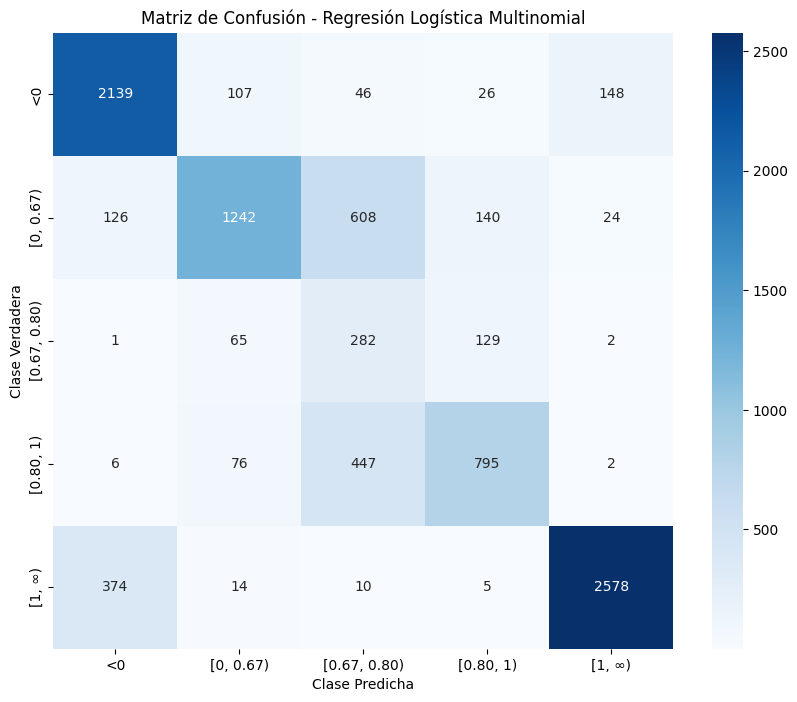

In [ ]:
# Matriz de Confusión para Regresión Logística Multinomial
plot_confusion_matrix(y_test, y_pred_logreg, 'Matriz de Confusión - Regresión Logística Multinomial')

La matriz de confusión muestra el desempeño del modelo de Regresión Logística Multinomial en el conjunto de prueba, ilustrando la distribución de predicciones correctas e incorrectas para cada clase. Las filas representan las categorías verdaderas, mientras que las columnas muestran las categorías predichas.

El modelo clasifica correctamente un alto número de observaciones en las clases `<0` (2139) y `[1, ∞)` (2578), como se evidencia por los valores elevados en la diagonal principal. Sin embargo, se observan confusiones significativas en las clases intermedias:
- La clase `[0.67, 0.80)` presenta errores frecuentes, siendo mal clasificada como `[0, 0.67)` (608) y `[0.80, 1)` (129).
- Para la clase `[0.80, 1)`, las confusiones más comunes ocurren con la clase `[0.67, 0.80)` (447).

La matriz de confusión indica que el modelo tiene un buen desempeño en las clases extremas (`<0` y `[1, ∞)`), pero enfrenta dificultades para diferenciar las clases intermedias, como `[0.67, 0.80)` y `[0.80, 1)`. 

In [ ]:
# Binarizar las etiquetas para ROC
y_test_binarized = label_binarize(y_test, classes=list(label_mapping.keys()))
n_classes = y_test_binarized.shape[1]

# Obtener las probabilidades predichas para Regresión Logística Multinomial
y_score_logreg = pipeline_logreg.predict_proba(X_test)


In [ ]:
best_logreg = grid_search.best_estimator_
print("Mejores parámetros de Regresión Logística:", grid_search.best_params_)

Mejores parámetros de Regresión Logística: {'classifier__C': 100, 'classifier__penalty': 'l2'}


In [ ]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2']
}

grid_search = GridSearchCV(pipeline_logreg, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Cantidad '
                                                                          'de '
                                                                          'años '
                                                                          'de '
                                                                          'la '
                                                                          'empresa',
                                                                          'Fecha '
                                                                          'de '
                                                                          'Corte',
                                                                          'Total '
                                                                          'de '
                                                                          'activos '
                                                                          '(Assets)',
                                                                          'Razón '
                                                                          'corriente',
                                                                          'Rotación '
                                                                          'cartera',
                                                                          'ROA',
                                                                          'ROE',
                                                                          'Nivel '
                                                                          'de '
                                                                          'endeudamiento',
                                                                          'Generación '
                                                                          'Efectivo',
                                                                          'SD',
                                                                          'FDC',
                                                                          'Tasa '
                                                                          'de '
                                                                          'Desempleo',
                                                                          'Tasa '
                                                                          'de '
                                                                          '...
                                                                          'Departamento '
                                                                          'de '
                                                                          'la '
                                                                          'dirección '
                                                                          'del '
                                                                          'domicilio',
                                                                          'Clasificación '
                                                                          'Industrial '
                                                                          'Internacional '
                                                                          'Uniforme '
                                                                          'Versión '
                                                                          '4 '
                                                                          

El código utiliza **GridSearchCV** para optimizar los hiperparámetros del modelo de Regresión Logística Multinomial dentro de un pipeline, evaluando diferentes valores de la regularización `C` y el tipo de penalización (`l2`). Los mejores hiperparámetros encontrados fueron `C=100` y `penalty='l2'`, lo que sugiere que el modelo alcanza un mejor desempeño con una regularización más suave y penalización de norma `l2`. Este enfoque, que integra el preprocesamiento y el modelo, asegura consistencia y un ajuste óptimo mediante validación cruzada (`cv=5`), mejorando la capacidad del modelo para generalizar en nuevos datos. La búsqueda exhaustiva garantiza un modelo robusto y eficiente adaptado a las características del conjunto de datos.

In [ ]:
rfe = RFE(estimator=LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced'), n_features_to_select=20)


In [ ]:
pipeline_rfe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfe),
    ('classifier', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced'
    ))
])

In [ ]:
# Evaluar el mejor modelo de Regresión Logística
y_pred_best_logreg = best_logreg.predict(X_test)
print("\nReporte de clasificación - Mejor Regresión Logística:")
print(classification_report(y_test, y_pred_best_logreg, target_names=label_mapping.values()))


Reporte de clasificación - Mejor Regresión Logística:
              precision    recall  f1-score   support

          <0       0.89      0.98      0.93      2466
   [0, 0.67)       0.98      0.74      0.84      2140
[0.67, 0.80)       0.40      0.90      0.55       479
   [0.80, 1)       0.95      0.81      0.88      1326
      [1, ∞)       0.99      0.95      0.97      2981

    accuracy                           0.89      9392
   macro avg       0.84      0.88      0.84      9392
weighted avg       0.93      0.89      0.90      9392



El mejor modelo de Regresión Logística Multinomial, optimizado con GridSearchCV y selección de características mediante RFE, alcanzó un desempeño destacado con una precisión general del **89%** y un F1-score ponderado de **0.90**, mostrando un balance efectivo entre precisión y recall. Las clases `<0`, `[0, 0.67)`, `[0.80, 1)` y `[1, ∞)` presentan altos F1-scores (entre 0.84 y 0.97), reflejando un excelente desempeño del modelo en estas categorías. Aunque la clase `[0.67, 0.80)` mejoró su recall (0.90), su precisión baja (0.40) indica que sigue siendo la más desafiante, lo que resalta la necesidad de ajustes adicionales, como balanceo de clases o refinamiento de hiperparámetros. 

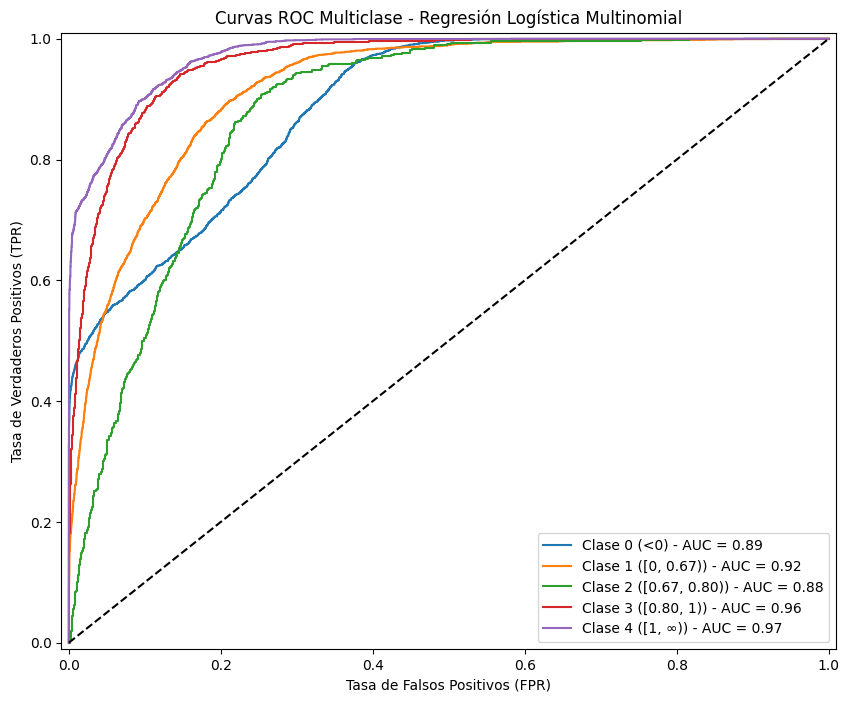

In [ ]:
# Función para plotear Curvas ROC
def plot_roc(y_true, y_score, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Clase {i} ({label_mapping[i]}) - AUC = {roc_auc[i]:0.2f}')

    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Curvas ROC para Regresión Logística Multinomial
plot_roc(y_test_binarized, y_score_logreg, 'Curvas ROC Multiclase - Regresión Logística Multinomial')


La gráfica de curvas ROC multiclase muestra un desempeño sólido del modelo optimizado de Regresión Logística Multinomial, con áreas bajo la curva (AUC) altas para la mayoría de las clases. Las clases extremas `[1, ∞)` y `[0.80, 1)` tienen los mejores resultados, con AUC de 0.97 y 0.96 respectivamente, lo que refleja una alta capacidad de discriminación. Aunque la clase `[0.67, 0.80)` presenta un AUC menor (0.88), sigue mostrando un desempeño aceptable. Estas curvas confirman que el modelo clasifica de manera efectiva la mayoría de las categorías, siendo particularmente confiable en las clases mayoritarias y extremos, con oportunidades de mejora en la clase `[0.67, 0.80)` para incrementar aún más su precisión global.

In [ ]:
pipeline_rfe.fit(X_train, y_train)
y_pred_rfe = pipeline_rfe.predict(X_test)
print("\nReporte de clasificación - Regresión Logística con RFE:")
print(classification_report(y_test, y_pred_rfe, target_names=label_mapping.values()))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 


Reporte de clasificación - Regresión Logística con RFE:
              precision    recall  f1-score   support

          <0       0.91      0.84      0.87      2466
   [0, 0.67)       0.72      0.81      0.76      2140
[0.67, 0.80)       0.31      0.51      0.38       479
   [0.80, 1)       0.84      0.72      0.78      1326
      [1, ∞)       0.99      0.92      0.95      2981

    accuracy                           0.82      9392
   macro avg       0.75      0.76      0.75      9392
weighted avg       0.85      0.82      0.83      9392



El modelo de Regresión Logística optimizado con RFE muestra un desempeño general aceptable, alcanzando una precisión global del **82%** y un F1-score ponderado de **0.83**. Las clases extremas, como `<0` y `[1, ∞)`, destacan con altos F1-scores de **0.87** y **0.95**, respectivamente, mientras que las clases intermedias `[0, 0.67)` y `[0.80, 1)` presentan un rendimiento moderado con F1-scores de **0.76** y **0.78**. La clase `[0.67, 0.80)` sigue siendo la más problemática, con un F1-score de **0.38** y una precisión baja de **0.31**, indicando dificultades para distinguir esta categoría. 

In [ ]:
# a. Regresión Logística Multinomial
logreg = pipeline_logreg.named_steps['classifier']
preprocessor_logreg = pipeline_logreg.named_steps['preprocessor']
feature_names_logreg = preprocessor_logreg.get_feature_names_out()

coefficients = logreg.coef_

# Crear un DataFrame para los coeficientes
coef_df = pd.DataFrame(coefficients, columns=feature_names_logreg)
coef_df['Clase'] = logreg.classes_

# Reorganizar las columnas
coef_df = coef_df.set_index('Clase')

print("Coeficientes del modelo - Regresión Logística Multinomial:")
print(coef_df)

Coeficientes del modelo - Regresión Logística Multinomial:
       num__Cantidad de años de la empresa  num__Fecha de Corte  \
Clase                                                             
0                                 0.000242            -0.005498   
1                                -0.030214            -0.039216   
2                                 0.046792            -0.011861   
3                                 0.040271             0.023981   
4                                -0.057091             0.032593   

       num__Total de activos (Assets)  num__Razón corriente  \
Clase                                                         
0                            0.353258              0.218359   
1                            0.427160              0.312202   
2                           -0.478168             -0.976538   
3                           -0.562466              0.285277   
4                            0.260216              0.160700   

       num__Rotación cartera 

Los coeficientes del modelo de Regresión Logística Multinomial permite identificar la influencia de cada variable en las probabilidades de clasificación para cada clase. Utilizando el pipeline, se extrajeron los coeficientes asociados a las características preprocesadas, organizándolos en un DataFrame estructurado por clase. Este enfoque facilita la interpretación del impacto individual de cada variable sobre las decisiones del modelo, proporcionando insights clave sobre qué factores son más relevantes para determinar la pertenencia a una clase específica. 

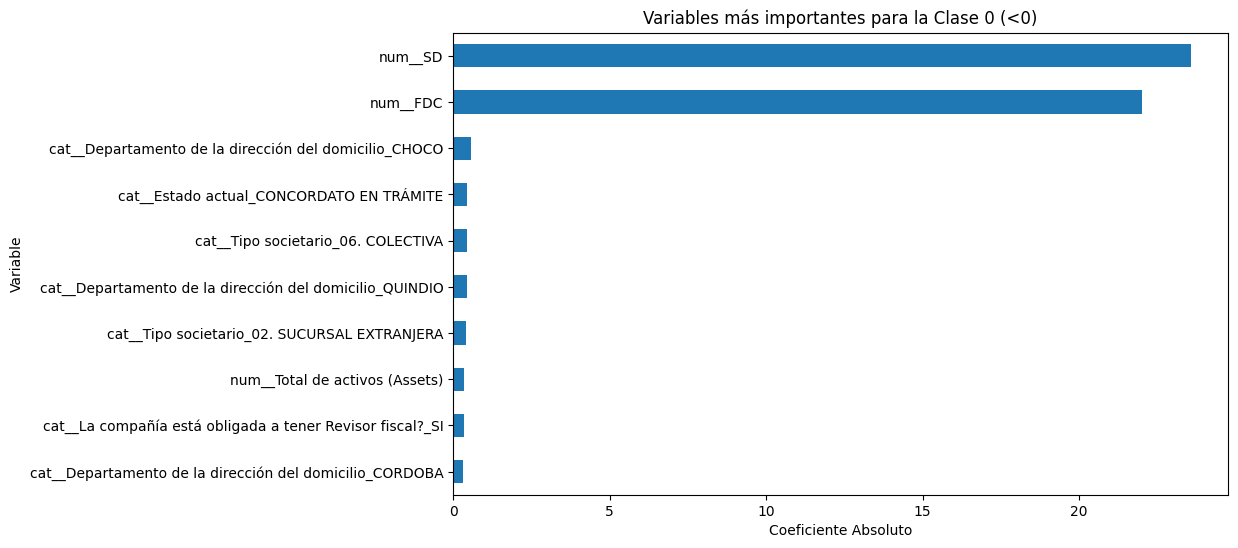

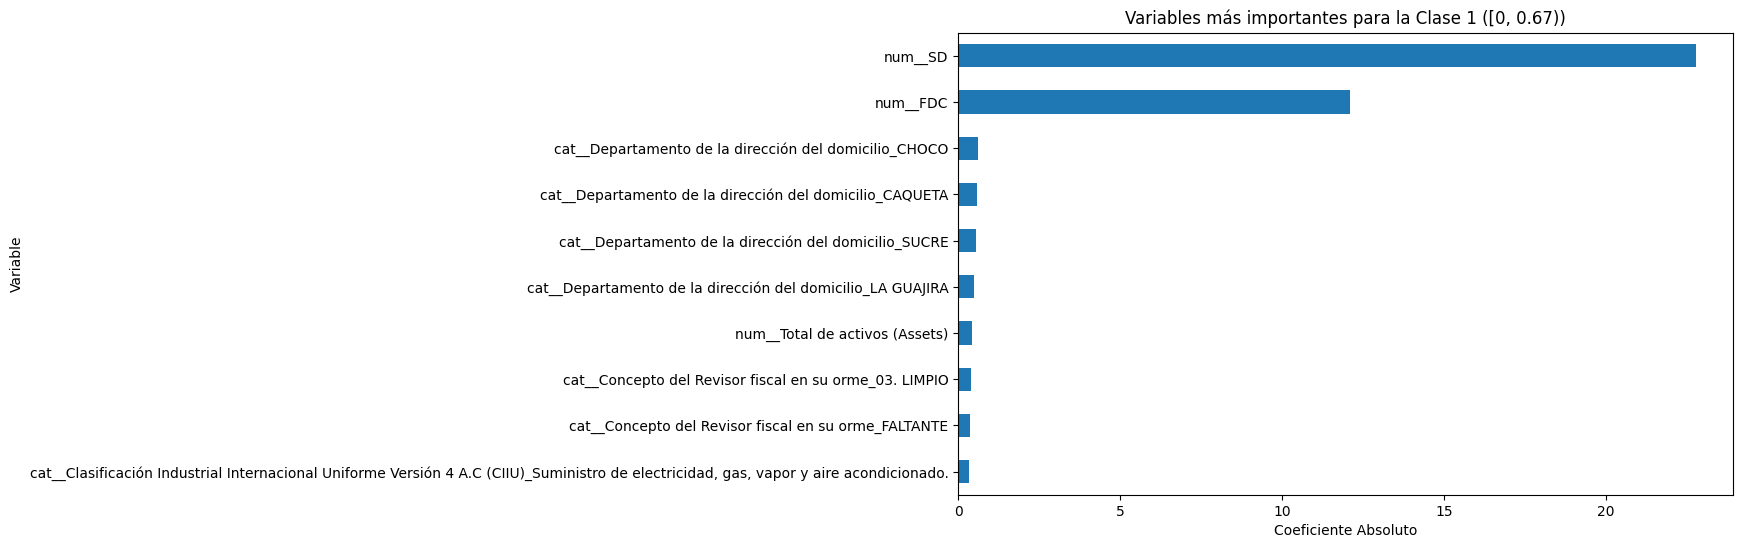

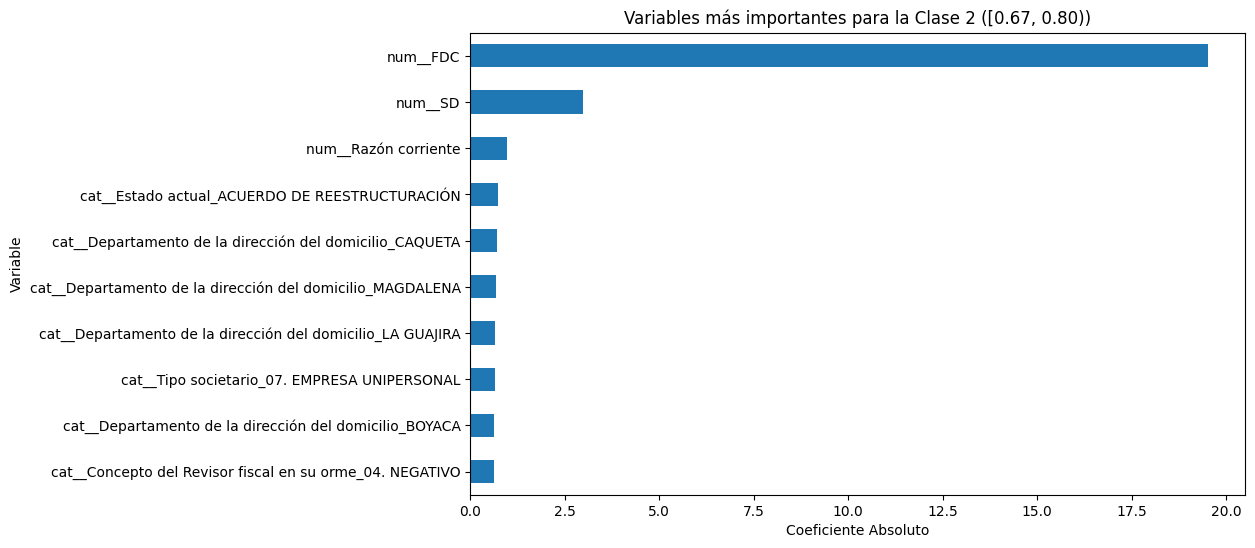

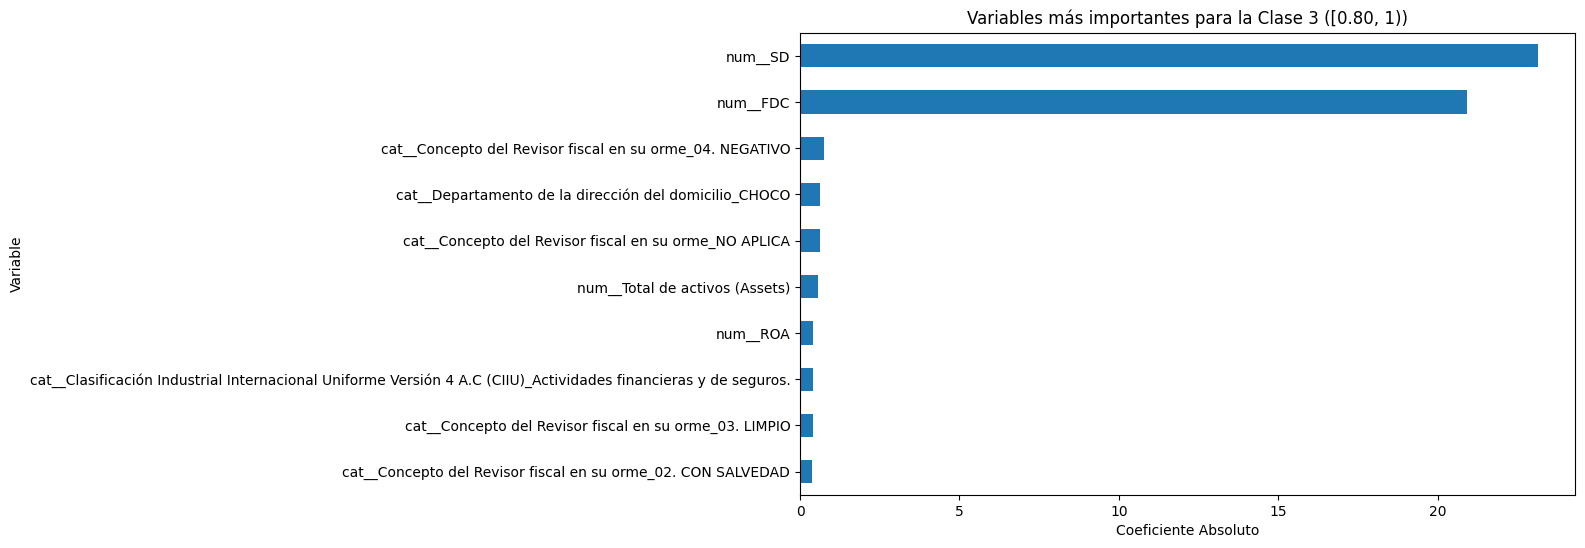

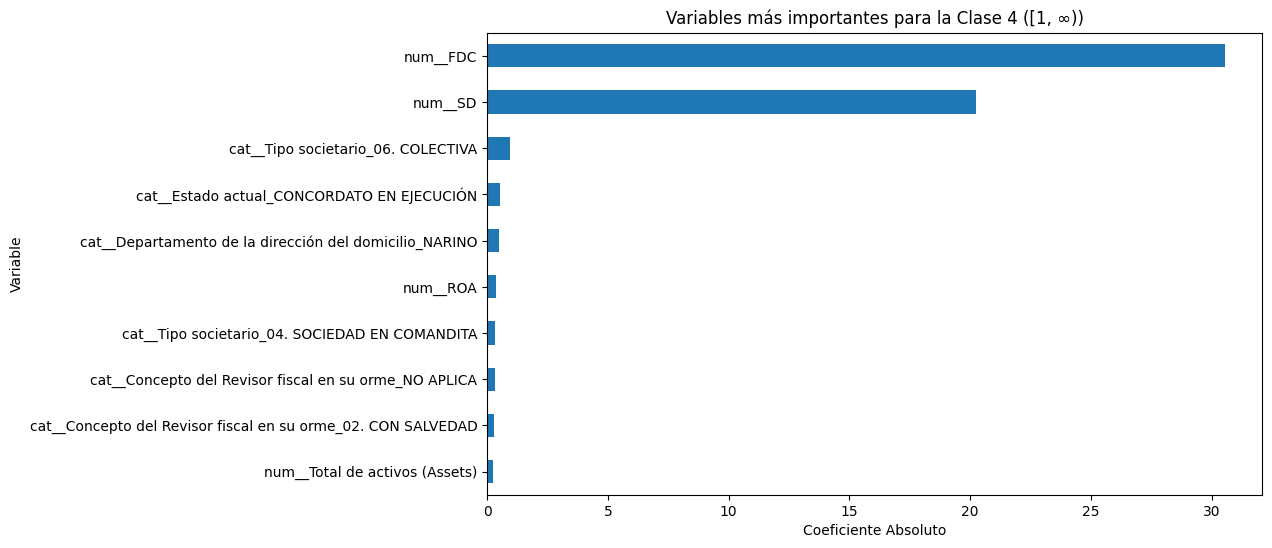

In [ ]:
# Visualizar los coeficientes más importantes por clase
for clase in logreg.classes_:
    coef_clase = coef_df.loc[clase].abs().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,6))
    coef_clase.sort_values().plot(kind='barh')
    plt.title(f'Variables más importantes para la Clase {clase} ({label_mapping[clase]})')
    plt.xlabel('Coeficiente Absoluto')
    plt.ylabel('Variable')
    plt.show()

El análisis de los coeficientes del modelo de regresión logística multinomial permitió identificar las variables más relevantes para cada una de las clases en el modelo, reflejando la influencia de las características tanto numéricas como categóricas. Las gráficas generadas para cada clase mostraron que variables como el servicio de deuda (SD) y el flujo de caja disponible (FDC) destacan consistentemente en todas las clases por su alta contribución predictiva, indicando su importancia en la clasificación de las categorías. Adicionalmente, variables categóricas como el tipo societario y la ubicación geográfica de la empresa también aportaron valor significativo en ciertas clases, reflejando una interacción entre factores financieros y estructurales en el desempeño de las empresas. 

In [ ]:
joblib.dump(pipeline_logreg, 'modelo_logreg.joblib')

['modelo_logreg.joblib']

### Random Forest

In [ ]:
# Filtrar datos si es necesario (ejemplo: eliminar filas con 'SD' <= 0)
data = data[data['SD'] > 0].copy()

# Convertir 'Fecha de Corte' a entero si no lo es
data['Fecha de Corte'] = data['Fecha de Corte'].astype(int)

# Crear la variable objetivo 'FDC_FLC_categoria'
bins = [-np.inf, 0, 0.67, 0.80, 1, np.inf]
labels = ['<0', '[0, 0.67)', '[0.67, 0.80)', '[0.80, 1)', '[1, ∞)']
data['FDC_FLC_categoria'] = pd.cut(data['FDC/FLC'], bins=bins, labels=labels, right=False)

# Convertir variables categóricas a tipo 'category'
categorical_vars = [
    'Estado actual',
    'Concepto del Revisor fiscal en su orme',
    'La compañía está obligada a tener Revisor fiscal?',
    'Tipo societario',
    'Departamento de la dirección del domicilio',
    'Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)'
]
for var in categorical_vars + ['FDC_FLC_categoria']:
    data[var] = data[var].astype('category')

# Codificar la variable objetivo
data['FDC_FLC_categoria_code'] = data['FDC_FLC_categoria'].cat.codes

# 2. Definir las Etiquetas y Crear `label_mapping`
labels = ['<0', '[0, 0.67)', '[0.67, 0.80)', '[0.80, 1)', '[1, ∞)']
label_mapping = {i: label for i, label in enumerate(labels)}

# Verificar el mapeo
print("Label Mapping:")
for code, label in label_mapping.items():
    print(f"{code}: {label}")

# 3. Definir las Variables del Modelo
model_numeric_vars = [
    'Cantidad de años de la empresa',
    'Total de activos (Assets)',
    'Total pasivos (Liabilities)',
    'Razón corriente',
    'Rotación cartera',
    'Rotación proveedores',
    'ROA',
    'ROE',
    'Nivel de endeudamiento',
    'Generación Efectivo',
    'SD',
    'FDC',
    'Tasa de Desempleo',
    'Tasa de Ocupación',
    'PIB',
    'PIB DEP'
]

Label Mapping:
0: <0
1: [0, 0.67)
2: [0.67, 0.80)
3: [0.80, 1)
4: [1, ∞)


In [ ]:
model_categorical_vars = categorical_vars 

model_vars = model_numeric_vars + model_categorical_vars

available_years = data['Fecha de Corte'].unique()

In [ ]:

numeric_features = model_numeric_vars
categorical_features = model_categorical_vars

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, model_numeric_vars),
        ('cat', categorical_transformer, model_categorical_vars)
    ])


# Define the pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])


In [ ]:
for train_idx, test_idx in time_series_splits:
    X_train, X_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Entrenar el modelo
    pipeline_rf.fit(X_train, y_train)

    # Predecir
    y_pred_rf = pipeline_rf.predict(X_test)


print("\nReporte de clasificación - Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=label_mapping.values()))


Reporte de clasificación - Random Forest:
              precision    recall  f1-score   support

          <0       0.94      0.80      0.86      2466
   [0, 0.67)       0.78      1.00      0.88      2140
[0.67, 0.80)       0.61      0.02      0.04       479
   [0.80, 1)       0.93      0.85      0.88      1326
      [1, ∞)       0.85      0.96      0.90      2981

    accuracy                           0.86      9392
   macro avg       0.82      0.72      0.71      9392
weighted avg       0.86      0.86      0.84      9392



El modelo Random Forest fue evaluado utilizando una estructura temporal de entrenamiento y prueba, obteniendo un reporte de clasificación que muestra un desempeño robusto en varias clases. La precisión más alta se observa en las clases "<0" y "[1, ∞)" con valores de 0.94 y 0.85 respectivamente, destacando su capacidad para clasificar correctamente estos casos. Sin embargo, para la clase "[0.67, 0.80)", el modelo presenta desafíos con un F1-score de solo 0.04, indicando dificultades para manejar esta categoría específica. Con una exactitud general de 0.86 y una media ponderada en las métricas de precisión, recall y F1-score superior a 0.84, el modelo muestra un rendimiento aceptable, aunque podría beneficiarse de ajustes adicionales para mejorar en clases minoritarias.

In [ ]:
pipeline_rf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Cantidad de años de la '
                                                   'empresa',
                                                   'Fecha de Corte',
                                                   'Total de activos (Assets)',
                                                   'Total pasivos '
                                                   '(Liabilities)',
                                                   'Razón corriente',
                                                   'Rotación cartera',
                                                   'Rotación proveedores',
                                                   'ROA', 'ROE',
                                                   'Nivel de endeudamiento',
                                                   'Generación Efectivo', 'S...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Estado actual',
                                                   'Concepto del Revisor '
                                                   'fiscal en su orme',
                                                   'La compañía está obligada '
                                                   'a tener Revisor fiscal?',
                                                   'Tipo societario',
                                                   'Departamento de la '
                                                   'dirección del domicilio',
                                                   'Clasificación Industrial '
                                                   'Internacional Uniforme '
                                                   'Versión 4 A.C (CIIU)'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

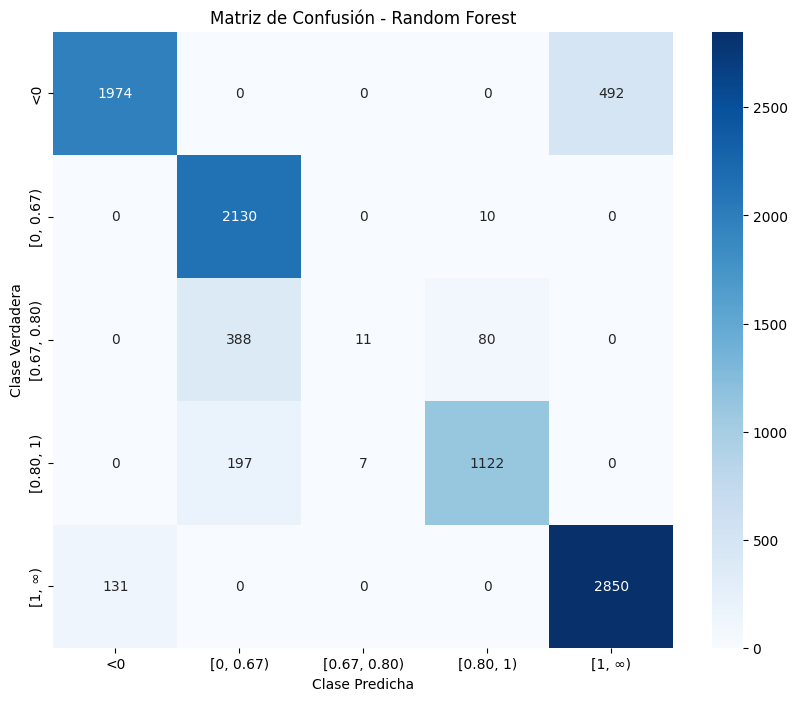

In [ ]:
# Matriz de Confusión para Random Forest
plot_confusion_matrix(y_test, y_pred_rf, 'Matriz de Confusión - Random Forest')

In [ ]:
y_score_rf = pipeline_rf.predict_proba(X_test)

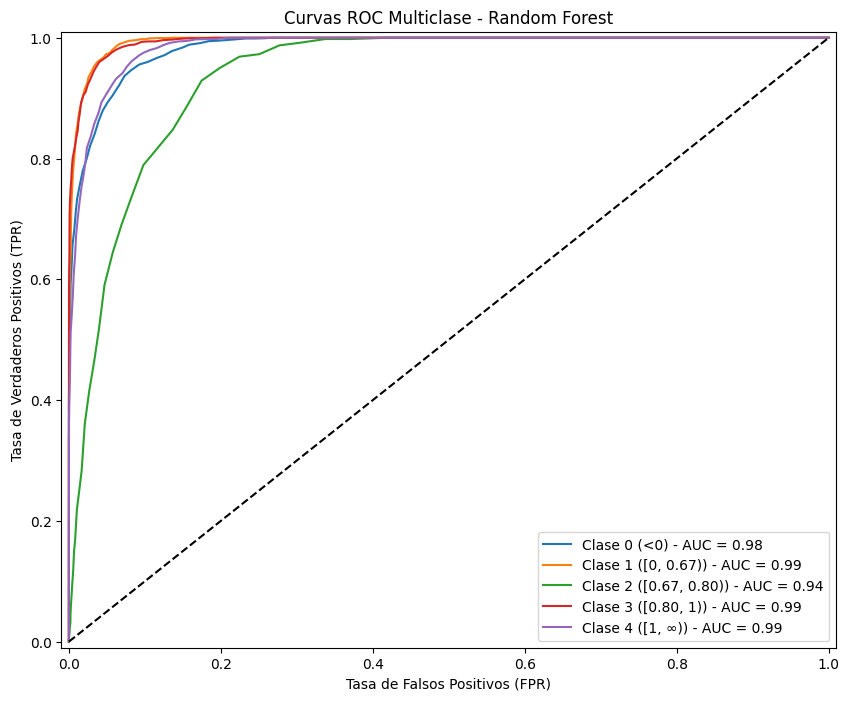

In [ ]:

plot_roc(y_test_binarized, y_score_rf, 'Curvas ROC Multiclase - Random Forest')


El modelo de Random Forest mostró un desempeño notable en la clasificación multiclase, logrando un accuracy global del 86% y valores de AUC superiores a 0.94 para todas las clases. Aunque presentó alta precisión en clases predominantes como `[1, ∞)` y `<0`, su capacidad para identificar correctamente la clase `[0.67, 0.80)` fue limitada debido al bajo recall (2%) en esta categoría. Además, la matriz de confusión reveló un desafío en la correcta clasificación de muestras minoritarias, indicando que estas fueron confundidas principalmente con clases adyacentes.

In [ ]:
importances_by_year = {}

for year in years:
    data_year = data[data['Fecha de Corte'] == year]
    X_year = data_year[model_vars]
    y_year = data_year['FDC_FLC_categoria_code']

    if X_year.shape[0] < 50:
        print(f"Año {year} omitido por tener pocas muestras.")
        continue

    X_year = X_year.dropna()
    y_year = y_year.loc[X_year.index]

    # Entrenar el modelo
    rf_year = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced'
        ))
    ])
    rf_year.fit(X_year, y_year)

    # Obtener importancias
    importances_year = rf_year.named_steps['classifier'].feature_importances_
    feature_names_year = rf_year.named_steps['preprocessor'].get_feature_names_out()

    # Guardar las importancias
    importances_by_year[year] = pd.Series(importances_year, index=feature_names_year)

    print(f"Modelo entrenado para el año {year}.")

Modelo entrenado para el año 2017.
Modelo entrenado para el año 2018.
Modelo entrenado para el año 2019.
Modelo entrenado para el año 2020.
Modelo entrenado para el año 2021.
Modelo entrenado para el año 2022.
Modelo entrenado para el año 2023.


Se entrenó un modelo Random Forest para cada año disponible en los datos, después de filtrar por años con suficientes muestras (más de 50). Los pasos incluyen la preparación de datos para cada año, manejo de valores nulos y uso de una pipeline para preprocesamiento y entrenamiento del modelo. Las importancias de las características se calculan y guardan para cada año, utilizando los nombres de las variables procesadas por la pipeline.

In [ ]:
# Crear un DataFrame de importancias por año
importances_df_year = pd.DataFrame(importances_by_year).T

# Seleccionar las variables más importantes en promedio
mean_importances = importances_df_year.mean().sort_values(ascending=False)
top_features_time = mean_importances.head(5).index  

In [ ]:
importances = pipeline_rf.named_steps['classifier'].feature_importances_
feature_names = pipeline_rf.named_steps['preprocessor'].get_feature_names_out()

importances_df = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

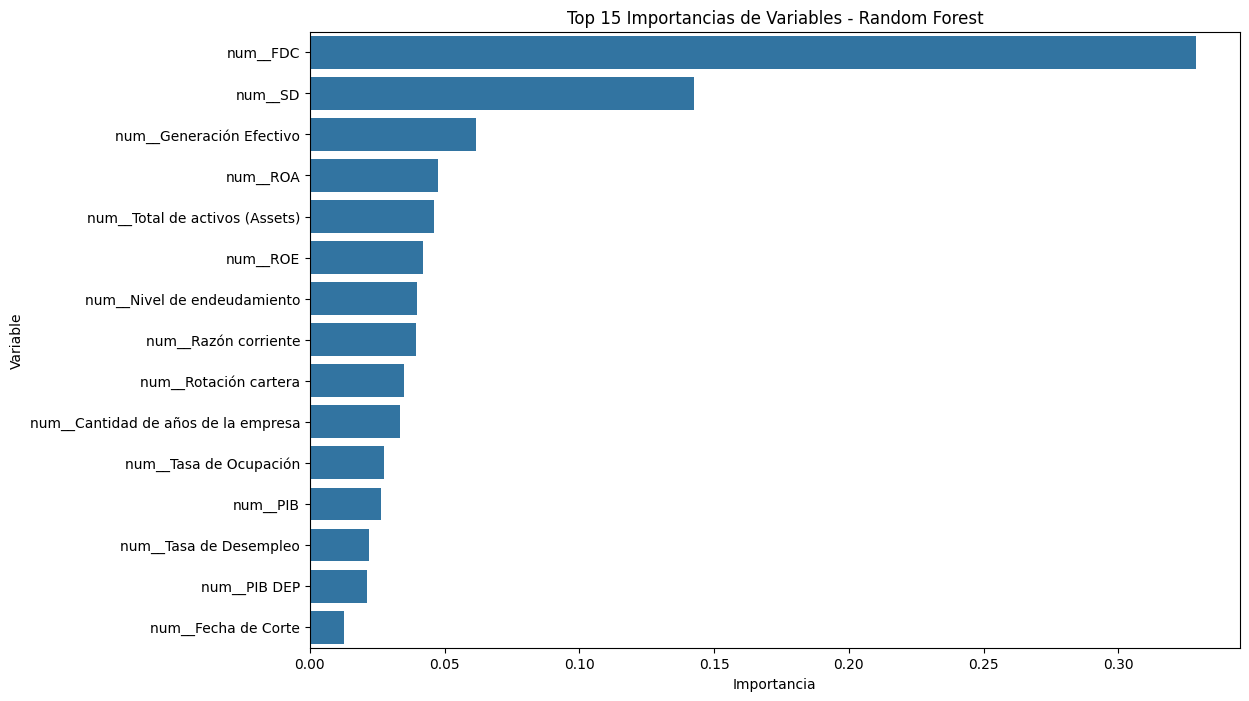

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x='Importancia', y='Variable', data=importances_df.head(15))
plt.title('Top 15 Importancias de Variables - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

La gráfica ilustra cómo las cinco variables más importantes en el modelo Random Forest han contribuido a las predicciones a lo largo de los años. Se observa que `num_FDC` y `num_SD` mantienen una importancia constante y destacada, lo que sugiere su papel crucial en el análisis durante todo el período evaluado. Otras variables, como `num_Generación Efectivo` y `num_ROA`, muestran menor impacto, pero permanecen relevantes en las predicciones. 

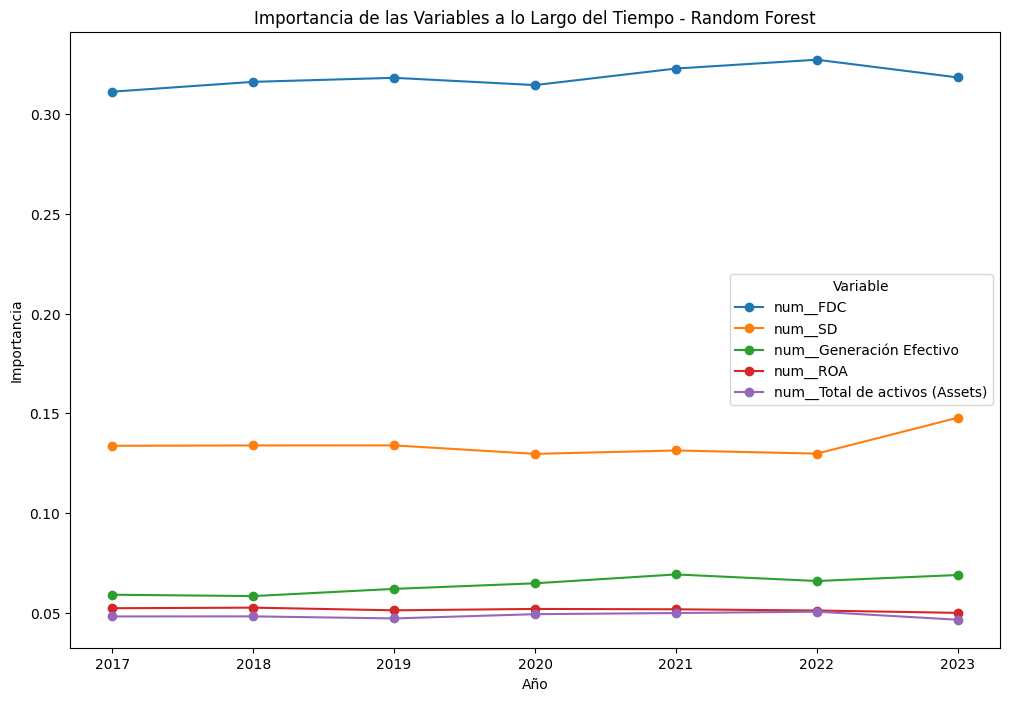

In [ ]:
# Plotear la importancia a lo largo del tiempo
plt.figure(figsize=(12, 8))
for feature in top_features_time:
    plt.plot(importances_df_year.index, importances_df_year[feature], marker='o', label=feature)
plt.xlabel('Año')
plt.ylabel('Importancia')
plt.title('Importancia de las Variables a lo Largo del Tiempo - Random Forest')
plt.legend(title='Variable')
plt.show()

La gráfica compara la importancia promedio de las variables clave (`num_FDC`, `num_SD`, `num_Generación Efectivo`, `num_ROA`, `num_Total de activos (Assets)`) en el modelo Random Forest a lo largo del tiempo, desde 2017 hasta 2023. Destaca que `num_FDC` lidera consistentemente como la variable más significativa, seguida por `num_SD`, que también muestra una tendencia estable, aunque ligeramente creciente hacia 2023. Las otras variables mantienen un impacto menor pero constante en la predicción. 

In [ ]:
# Guardar el modelo de Random Forest
joblib.dump(pipeline_rf, 'modelo_rf.joblib')

print("Modelos guardados exitosamente en archivos Joblib.")

Modelos guardados exitosamente en archivos Joblib.


### XGBOOOST

In [ ]:
data = pd.read_excel(filepath)

# Filtrar datos si es necesario (ejemplo: eliminar filas con 'SD' <= 0)
data = data[data['SD'] > 0].copy()

# Convertir 'Fecha de Corte' a entero si no lo es
data['Fecha de Corte'] = data['Fecha de Corte'].astype(int)

# Crear la variable objetivo 'FDC_FLC_categoria'
bins = [-np.inf, 0, 0.67, 0.80, 1, np.inf]
labels = ['<0', '[0, 0.67)', '[0.67, 0.80)', '[0.80, 1)', '[1, ∞)']
data['FDC_FLC_categoria'] = pd.cut(data['FDC/FLC'], bins=bins, labels=labels, right=False)


In [ ]:
# Convertir variables categóricas a tipo 'category'
categorical_vars = [
    'Estado actual',
    'Concepto del Revisor fiscal en su orme',
    'La compañía está obligada a tener Revisor fiscal?',
    'Tipo societario',
    'Departamento de la dirección del domicilio',
    'Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)'
]
for var in categorical_vars + ['FDC_FLC_categoria']:
    data[var] = data[var].astype('category')

# Codificar la variable objetivo
data['FDC_FLC_categoria_code'] = data['FDC_FLC_categoria'].cat.codes

# Definir las Etiquetas y Crear `label_mapping`
labels = ['<0', '[0, 0.67)', '[0.67, 0.80)', '[0.80, 1)', '[1, ∞)']
label_mapping = {i: label for i, label in enumerate(labels)}

# Verificar el mapeo
print("Label Mapping:")
for code, label in label_mapping.items():
    print(f"{code}: {label}")

# Definir las Variables del Modelo
model_numeric_vars = [
    'Cantidad de años de la empresa',
    'Total de activos (Assets)',
    'Total pasivos (Liabilities)',
    'Razón corriente',
    'Rotación cartera',
    'Rotación proveedores',
    'ROA',
    'ROE',
    'Nivel de endeudamiento',
    'Generación Efectivo',
    'SD',
    'FDC',
    'Tasa de Desempleo',
    'Tasa de Ocupación',
    'PIB',
    'PIB DEP'
]

model_categorical_vars = categorical_vars  # Ya definidas y convertidas a 'category'

model_vars = model_numeric_vars + model_categorical_vars

Label Mapping:
0: <0
1: [0, 0.67)
2: [0.67, 0.80)
3: [0.80, 1)
4: [1, ∞)


In [ ]:
# Limpiar los Datos (Eliminar filas con NaN)
train_data = train_data.dropna(subset=model_vars + ['FDC_FLC_categoria_code'])
test_data = test_data.dropna(subset=model_vars + ['FDC_FLC_categoria_code'])

In [ ]:
# Reducir la Multicolinealidad
# Calcular la matriz de correlación
corr_matrix = train_data[model_numeric_vars].corr().abs()

# Seleccionar la parte superior de la matriz de correlación
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encontrar pares con correlación mayor a 0.8
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.8)]

print("Variables a eliminar por alta correlación:", to_drop_corr)

Variables a eliminar por alta correlación: ['Total pasivos (Liabilities)', 'Rotación proveedores']


In [ ]:
# Eliminar variables altamente correlacionadas
model_numeric_vars = [var for var in model_numeric_vars if var not in to_drop_corr]
model_vars = model_numeric_vars + model_categorical_vars

In [ ]:
# Definir el Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), model_numeric_vars),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), model_categorical_vars)
    ])

In [ ]:
# Definir el Pipeline para XGBoost
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=5,  # Ajusta según el número de clases
        eval_metric='mlogloss',
        use_label_encoder=False,
        n_jobs=-1,
        random_state=42
    ))
])

In [ ]:
# Entrenar el Modelo XGBoost
for train_idx, test_idx in time_series_splits:
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Entrenar el modelo
    pipeline_xgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[14:27:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Cantidad de años de la '
                                                   'empresa',
                                                   'Total de activos (Assets)',
                                                   'Razón corriente',
                                                   'Rotación cartera', 'ROA',
                                                   'ROE',
                                                   'Nivel de endeudamiento',
                                                   'Generación Efectivo', 'SD',
                                                   'FDC', 'Tasa de Desempleo',
                                                   'Tasa de Ocupación', 'PIB',
                                                   'PIB DEP']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='i...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1, num_class=5,
                               num_parallel_tree=None, ...))])

La estructura del pipeline para el modelo XGBoost consiste en dos componentes principales: un preprocesador de datos y el clasificador `XGBClassifier`. El preprocesador aplica transformaciones específicas a las variables numéricas, como escalado estándar con `StandardScaler`, y a las categóricas, utilizando `OneHotEncoder` para codificación. El clasificador XGBoost se configura para manejar problemas multiclase mediante la función objetivo `multi:softprob`, evaluando el error logarítmico (`mlogloss`). Este pipeline permite un procesamiento eficiente y entrenamiento del modelo en tareas de clasificación multiclase.

In [ ]:
# Evaluar el Modelo XGBoost
y_pred_xgb = pipeline_xgb.predict(X_test)
print("\nReporte de clasificación - XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=label_mapping.values()))


Reporte de clasificación - XGBoost:
              precision    recall  f1-score   support

          <0       0.98      0.98      0.98      2466
   [0, 0.67)       0.99      0.99      0.99      2140
[0.67, 0.80)       0.92      0.90      0.91       479
   [0.80, 1)       0.98      0.98      0.98      1326
      [1, ∞)       0.98      0.98      0.98      2981

    accuracy                           0.98      9392
   macro avg       0.97      0.97      0.97      9392
weighted avg       0.98      0.98      0.98      9392



El modelo XGBoost mostró un desempeño sobresaliente en el conjunto de prueba, con una precisión y un recall muy altos para todas las clases. La exactitud global (accuracy) alcanzó un 98%, indicando que el modelo predijo correctamente la mayoría de las observaciones. Las métricas promedio ponderado (weighted avg) y macro promedio (macro avg) también son consistentes, con valores de f1-score, precisión y recall superiores al 97%, lo que refleja un equilibrio en el rendimiento del modelo incluso para clases con menos datos, como `[0.67, 0.80)`. 

In [ ]:
# Visualizar la Matriz de Confusión
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=label_mapping.values(), columns=label_mapping.values())

    plt.figure(figsize=(10,8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predicha')
    plt.show()


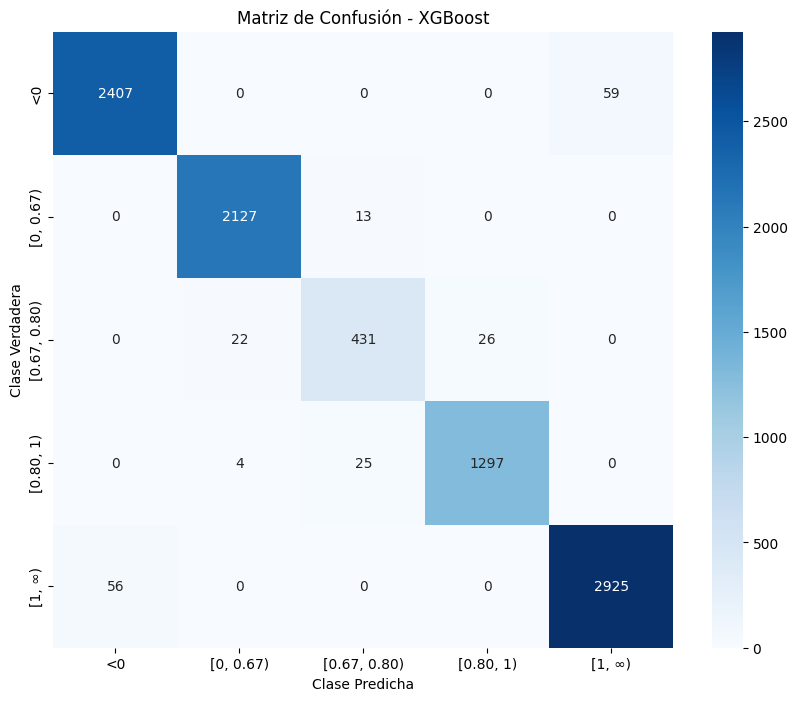

In [ ]:
# Matriz de Confusión para XGBoost
plot_confusion_matrix(y_test, y_pred_xgb, 'Matriz de Confusión - XGBoost')

La matriz de confusión del modelo XGBoost demuestra un desempeño sólido en la clasificación multiclase, con una gran mayoría de predicciones correctas en las clases principales. Las clases `<0`, `[0, 0.67)`, `[0.80, 1)`, y `[1, ∞)` tienen una alta cantidad de predicciones verdaderas positivas, mientras que la clase `[0.67, 0.80)` presenta más errores en comparación con las demás, aunque sigue siendo aceptable considerando su menor frecuencia en el conjunto de datos. En general, la matriz refleja un balance positivo, lo que confirma el alto rendimiento reportado en las métricas de clasificación.

In [ ]:
# Curvas ROC Multiclase
# Binarizar las etiquetas para ROC
y_test_binarized = label_binarize(y_test, classes=list(label_mapping.keys()))
n_classes = y_test_binarized.shape[1]

# Obtener las probabilidades predichas para XGBoost
y_score_xgb = pipeline_xgb.predict_proba(X_test)

In [ ]:
# Función para plotear Curvas ROC
def plot_roc(y_true, y_score, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Clase {i} ({label_mapping[i]}) - AUC = {roc_auc[i]:0.2f}')

    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

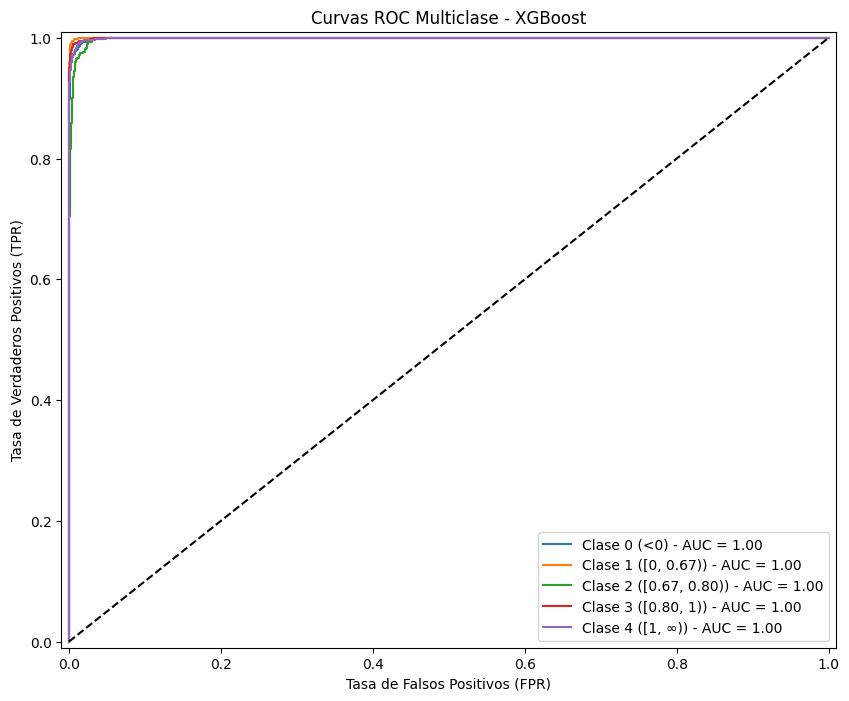

In [ ]:
# Curvas ROC para XGBoost
plot_roc(y_test_binarized, y_score_xgb, 'Curvas ROC Multiclase - XGBoost')

Las curvas ROC para el modelo XGBoost muestran un desempeño casi perfecto en todas las clases, con valores de AUC (Área Bajo la Curva) de 1.00 para todas las categorías. Esto indica una capacidad excepcional del modelo para distinguir correctamente entre las diferentes clases, tanto en términos de verdaderos positivos como de falsos positivos. La consistencia en el rendimiento para todas las clases refuerza la robustez del modelo y su adaptabilidad a diferentes patrones en los datos.

In [ ]:
# Importancia de las Variables en XGBoost
# Obtener las importancias de las variables
xgb_model = pipeline_xgb.named_steps['classifier']
preprocessor_xgb = pipeline_xgb.named_steps['preprocessor']
feature_names_xgb = preprocessor_xgb.get_feature_names_out()
importances_xgb = xgb_model.feature_importances_

In [ ]:
# Crear un DataFrame
importances_df_xgb = pd.DataFrame({
    'Variable': feature_names_xgb,
    'Importancia': importances_xgb
}).sort_values(by='Importancia', ascending=False)

print("Importancias de las variables - XGBoost:")
print(importances_df_xgb)

Importancias de las variables - XGBoost:
                                             Variable  Importancia
9                                            num__FDC     0.464286
8                                             num__SD     0.222003
26         cat__Tipo societario_03. SOCIEDAD LIMITADA     0.012360
36  cat__Departamento de la dirección del domicili...     0.011614
58  cat__Clasificación Industrial Internacional Un...     0.011249
..                                                ...          ...
21  cat__Concepto del Revisor fiscal en su orme_04...     0.000000
49  cat__Departamento de la dirección del domicili...     0.000000
47  cat__Departamento de la dirección del domicili...     0.000000
52  cat__Departamento de la dirección del domicili...     0.000000
66  cat__Clasificación Industrial Internacional Un...     0.000000

[68 rows x 2 columns]


El análisis de las importancias de las variables del modelo XGBoost indica que las características más relevantes para la clasificación son las variables numéricas **FDC** y **SD**, que tienen pesos significativamente más altos en comparación con el resto de las variables. Esto sugiere que estas dos variables tienen una influencia predominante en las predicciones del modelo. Las variables categóricas como el tipo societario y el departamento de la dirección del domicilio tienen importancias menores pero aún contribuyen de manera incremental. 

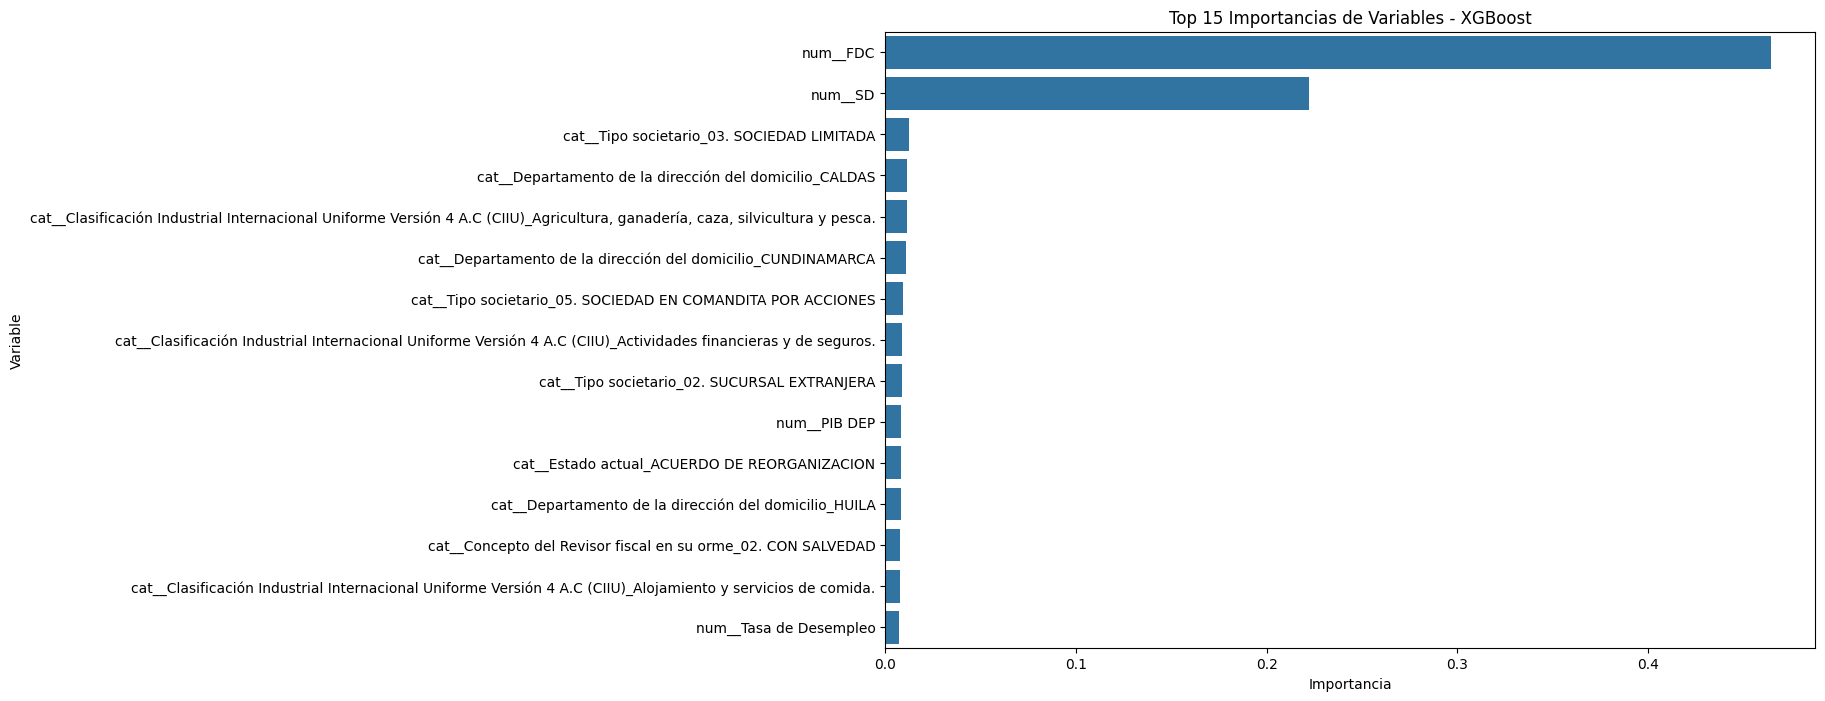

In [ ]:

plt.figure(figsize=(12,8))
sns.barplot(x='Importancia', y='Variable', data=importances_df_xgb.head(15))
plt.title('Top 15 Importancias de Variables - XGBoost')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

Las 15 principales variables más importantes según el modelo XGBoost destaca a **FDC** y **SD** como las características más relevantes para la clasificación, con importancias significativamente mayores en comparación con otras variables. Además, se observan contribuciones menores de variables categóricas como el tipo societario, la clasificación industrial y el departamento de domicilio. 

In [ ]:
# Visualizar Importancia de las Variables por Año
years = sorted(data['Fecha de Corte'].unique())

importances_by_year = {}

for year in years:
    data_year = data[data['Fecha de Corte'] == year]
    X_year = data_year[model_vars]
    y_year = data_year['FDC_FLC_categoria_code']

    if X_year.shape[0] < 50:
        print(f"Año {year} omitido por tener pocas muestras.")
        continue

    X_year = X_year.dropna()
    y_year = y_year.loc[X_year.index]

    # Entrenar el modelo XGBoost para el año
    pipeline_xgb_year = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(
            objective='multi:softprob',
            num_class=5,
            eval_metric='mlogloss',
            use_label_encoder=False,
            n_jobs=-1,
            random_state=42
        ))
    ])
    pipeline_xgb_year.fit(X_year, y_year)

    # Obtener importancias
    importances_year = pipeline_xgb_year.named_steps['classifier'].feature_importances_
    feature_names_year = pipeline_xgb_year.named_steps['preprocessor'].get_feature_names_out()

    # Guardar las importancias
    importances_by_year[year] = pd.Series(importances_year, index=feature_names_year)

    print(f"Modelo entrenado para el año {year}.")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[14:29:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Modelo entrenado para el año 2017.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[14:29:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Modelo entrenado para el año 2018.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[14:29:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Modelo entrenado para el año 2019.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[14:29:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Modelo entrenado para el año 2020.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[14:29:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Modelo entrenado para el año 2021.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[14:29:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Modelo entrenado para el año 2022.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[14:29:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Modelo entrenado para el año 2023.


In [ ]:
# Crear un DataFrame de importancias por año
importances_df_year = pd.DataFrame(importances_by_year).T

In [ ]:
# Seleccionar las variables más importantes en promedio
mean_importances = importances_df_year.mean().sort_values(ascending=False)
top_features_time = mean_importances.head(5).index  # Top 5 variables

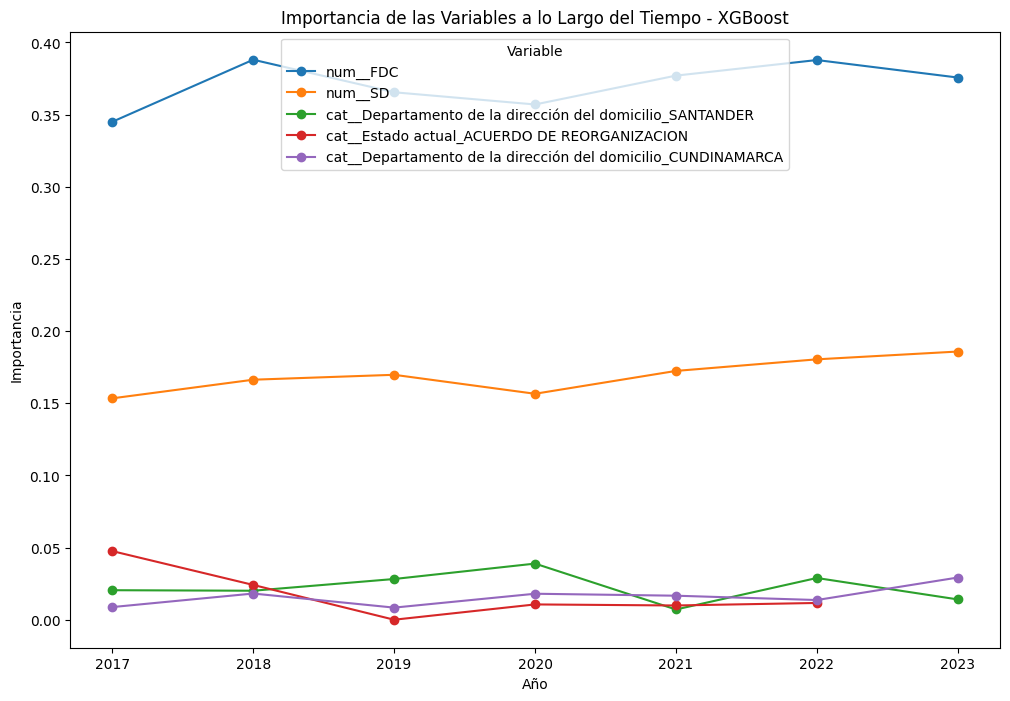

In [ ]:
# Plotear la importancia a lo largo del tiempo
plt.figure(figsize=(12, 8))
for feature in top_features_time:
    plt.plot(importances_df_year.index, importances_df_year[feature], marker='o', label=feature)
plt.xlabel('Año')
plt.ylabel('Importancia')
plt.title('Importancia de las Variables a lo Largo del Tiempo - XGBoost')
plt.legend(title='Variable')
plt.show()

El gráfico refleja la evolución temporal de la importancia de variables en un modelo XGBoost, destacando que las variables numéricas (`num_FDC` y `num_SD`) son consistentemente las más relevantes, con `num_SD` mostrando una tendencia creciente en su influencia. Por otro lado, las variables categóricas tienen menor impacto global pero presentan fluctuaciones que podrían indicar cambios en los patrones de los datos a lo largo del tiempo. Este análisis sugiere que las variables numéricas deben ser priorizadas en el modelo, mientras que las categóricas pueden aportar valor contextual en ciertos períodos. 

In [ ]:
# Guardar el Modelo en Archivo Pickle
with open('modelo_xgb.pkl', 'wb') as file:
    pickle.dump(pipeline_xgb, file)

In [ ]:
# Guardar el Modelo en Archivo Joblib (Opcional pero Recomendado)
joblib.dump(pipeline_xgb, 'modelo_xgb.joblib')

print("Modelo XGBoost guardado exitosamente en archivos Pickle y Joblib.")

Modelo XGBoost guardado exitosamente en archivos Pickle y Joblib.


### Modelo SVM

In [ ]:
# Definir las Variables del Modelo
model_numeric_vars = [
    'Cantidad de años de la empresa',
    'Total de activos (Assets)',
    'Total pasivos (Liabilities)',
    'Razón corriente',
    'Rotación cartera',
    'Rotación proveedores',
    'ROA',
    'ROE',
    'Nivel de endeudamiento',
    'Generación Efectivo',
    'SD',
    'FDC',
    'Tasa de Desempleo',
    'Tasa de Ocupación',
    'PIB',
    'PIB DEP'
]

model_categorical_vars = categorical_vars  # Ya definidas y convertidas a 'category'

model_vars = model_numeric_vars + model_categorical_vars

In [ ]:
# Reducir la Multicolinealidad
# Calcular la matriz de correlación
corr_matrix = train_data[model_numeric_vars].corr().abs()

# Seleccionar la parte superior de la matriz de correlación
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encontrar pares con correlación mayor a 0.8
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.8)]

print("Variables a eliminar por alta correlación:", to_drop_corr)

Variables a eliminar por alta correlación: ['Total pasivos (Liabilities)', 'Rotación proveedores']


In [ ]:
# Eliminar variables altamente correlacionadas
model_numeric_vars = [var for var in model_numeric_vars if var not in to_drop_corr]
model_vars = model_numeric_vars + model_categorical_vars

In [ ]:
# Definir el Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), model_numeric_vars),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), model_categorical_vars)
    ])

# Definir el Pipeline para SVM
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='rbf',  # Puedes probar otros kernels como 'linear', 'poly'
        C=1.0,
        gamma='scale',
        probability=True,  # Necesario para curvas ROC
        random_state=42
    ))
])

In [ ]:
for train_idx, test_idx in time_series_splits:
    X_train, X_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Entrenar el modelo
    pipeline_svm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Cantidad de años de la '
                                                   'empresa',
                                                   'Total de activos (Assets)',
                                                   'Razón corriente',
                                                   'Rotación cartera', 'ROA',
                                                   'ROE',
                                                   'Nivel de endeudamiento',
                                                   'Generación Efectivo', 'SD',
                                                   'FDC', 'Tasa de Desempleo',
                                                   'Tasa de Ocupación', 'PIB',
                                                   'PIB DEP']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Estado actual',
                                                   'Concepto del Revisor '
                                                   'fiscal en su orme',
                                                   'La compañía está obligada '
                                                   'a tener Revisor fiscal?',
                                                   'Tipo societario',
                                                   'Departamento de la '
                                                   'dirección del domicilio',
                                                   'Clasificación Industrial '
                                                   'Internacional Uniforme '
                                                   'Versión 4 A.C (CIIU)'])])),
                ('classifier', SVC(probability=True, random_state=42))])

In [ ]:
# Evaluar el Modelo SVM
y_pred_svm = pipeline_svm.predict(X_test)
print("\nReporte de clasificación - SVM:")
print(classification_report(y_test, y_pred_svm, target_names=label_mapping.values()))


Reporte de clasificación - SVM:
              precision    recall  f1-score   support

          <0       0.44      0.48      0.46      2466
   [0, 0.67)       0.44      0.53      0.49      2140
[0.67, 0.80)       0.00      0.00      0.00       479
   [0.80, 1)       0.73      0.26      0.39      1326
      [1, ∞)       0.62      0.76      0.69      2981

    accuracy                           0.53      9392
   macro avg       0.45      0.41      0.40      9392
weighted avg       0.52      0.53      0.50      9392



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



El reporte de clasificación del modelo SVM muestra un desempeño general bajo, con una accuracy de 0.53 y métricas globales desiguales, evidenciadas por un macro F1-score de 0.40. Las clases `[0.67, 0.80]` presentan un F1-score de 0.00, lo que indica que el modelo no las identifica correctamente, posiblemente debido a un desbalance en los datos o falta de características representativas. Aunque la clase `[1, ∞]` tiene el mejor rendimiento (F1-score de 0.69), las demás clases muestran problemas de recall y precisión.

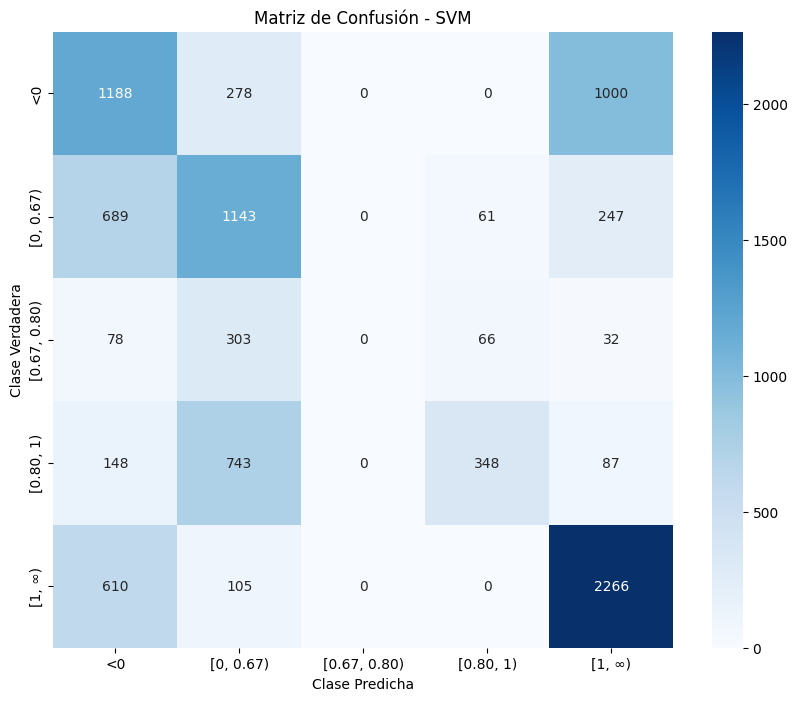

In [ ]:
# Visualizar la Matriz de Confusión
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=label_mapping.values(), columns=label_mapping.values())

    plt.figure(figsize=(10,8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predicha')
    plt.show()

# Matriz de Confusión para SVM
plot_confusion_matrix(y_test, y_pred_svm, 'Matriz de Confusión - SVM')

La matriz de confusión para el modelo SVM revela importantes desafíos en el desempeño de clasificación. Las clases `<0` y `[0, 0.67]` tienen una cantidad significativa de ejemplos mal clasificados, evidenciada por las desviaciones hacia otras clases, especialmente hacia `[1, ∞]`, lo que sugiere un sesgo del modelo hacia esta última categoría. La clase `[0.67, 0.80]` muestra un rendimiento crítico con casi todos sus valores clasificados incorrectamente como `[0, 0.67]` o `[0.80, 1]`, alineándose con el F1-score de 0 reportado anteriormente. Por otro lado, aunque la clase `[1, ∞]` tiene el mayor soporte correctamente clasificado (2266), también absorbe numerosos valores mal predichos de otras categorías, reflejando una alta precisión pero un desequilibrio general en las predicciones. 

In [ ]:
# Curvas ROC Multiclase
# Binarizar las etiquetas para ROC
y_test_binarized = label_binarize(y_test, classes=list(label_mapping.keys()))
n_classes = y_test_binarized.shape[1]

# Obtener las probabilidades predichas para SVM
y_score_svm = pipeline_svm.predict_proba(X_test)

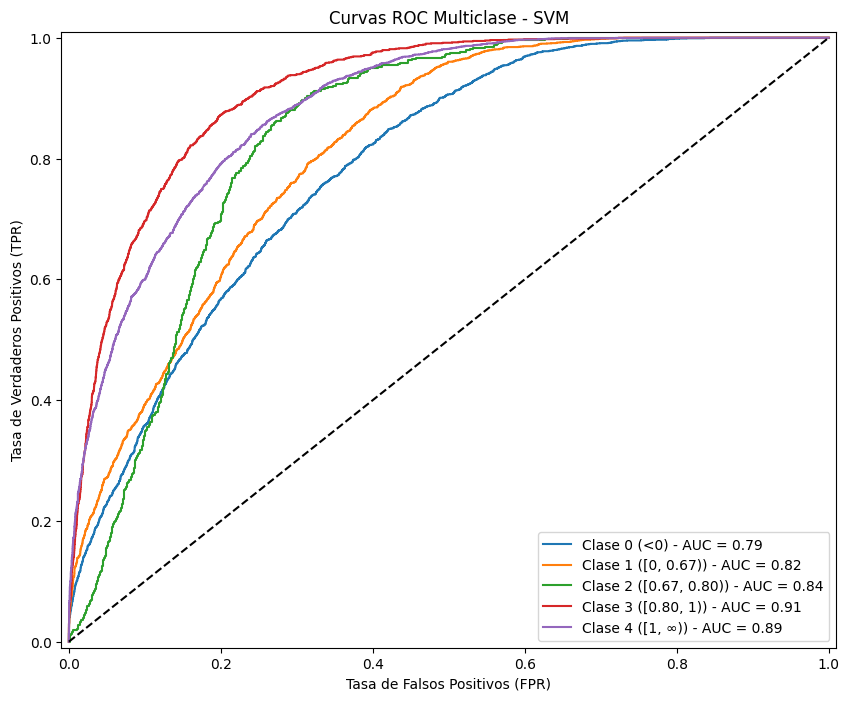

In [ ]:
# Función para plotear Curvas ROC
def plot_roc(y_true, y_score, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Clase {i} ({label_mapping[i]}) - AUC = {roc_auc[i]:0.2f}')

    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Curvas ROC para SVM
plot_roc(y_test_binarized, y_score_svm, 'Curvas ROC Multiclase - SVM')

Las curvas ROC del modelo SVM muestran un desempeño variado entre clases, con las categorías `[0.80, 1]` (AUC = 0.91) y `[1, ∞]` (AUC = 0.89) destacando como las mejor clasificadas, mientras que las demás tienen AUC moderadas (entre 0.79 y 0.84). Aunque los valores de AUC sugieren que el modelo distingue bien las clases en términos probabilísticos, esto no se traduce completamente en buen desempeño concreto, como evidenciado por las métricas de precisión y recall en clases como `[0.67, 0.80]`. 

In [ ]:
# Guardar el Modelo en Archivo Pickle
with open('modelo_svm.pkl', 'wb') as file:
    pickle.dump(pipeline_svm, file)

# Guardar el Modelo en Archivo Joblib (Opcional pero Recomendado)
joblib.dump(pipeline_svm, 'modelo_svm.joblib')

print("Modelo SVM guardado exitosamente en archivos Pickle y Joblib.")

Modelo SVM guardado exitosamente en archivos Pickle y Joblib.


### Modelo KNN

In [ ]:
# Crear la variable objetivo 'FDC_FLC_categoria'
bins = [-np.inf, 0, 0.67, 0.80, 1, np.inf]
labels = ['<0', '[0, 0.67)', '[0.67, 0.80)', '[0.80, 1)', '[1, ∞)']
data['FDC_FLC_categoria'] = pd.cut(data['FDC/FLC'], bins=bins, labels=labels, right=False)

# Convertir variables categóricas a tipo 'category'
categorical_vars = [
    'Estado actual',
    'Concepto del Revisor fiscal en su orme',
    'La compañía está obligada a tener Revisor fiscal?',
    'Tipo societario',
    'Departamento de la dirección del domicilio',
    'Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)'
]
for var in categorical_vars + ['FDC_FLC_categoria']:
    data[var] = data[var].astype('category')

# Codificar la variable objetivo
data['FDC_FLC_categoria_code'] = data['FDC_FLC_categoria'].cat.codes

# Definir las Etiquetas y Crear `label_mapping`
labels = ['<0', '[0, 0.67)', '[0.67, 0.80)', '[0.80, 1)', '[1, ∞)']
label_mapping = {i: label for i, label in enumerate(labels)}

In [ ]:
# Definir las Variables del Modelo
model_numeric_vars = [
    'Cantidad de años de la empresa',
    'Total de activos (Assets)',
    'Total pasivos (Liabilities)',
    'Razón corriente',
    'Rotación cartera',
    'Rotación proveedores',
    'ROA',
    'ROE',
    'Nivel de endeudamiento',
    'Generación Efectivo',
    'SD',
    'FDC',
    'Tasa de Desempleo',
    'Tasa de Ocupación',
    'PIB',
    'PIB DEP'
]

model_categorical_vars = categorical_vars  # Ya definidas y convertidas a 'category'

model_vars = model_numeric_vars + model_categorical_vars

In [ ]:
# Reducir la Multicolinealidad
# Calcular la matriz de correlación
corr_matrix = train_data[model_numeric_vars].corr().abs()

# Seleccionar la parte superior de la matriz de correlación
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encontrar pares con correlación mayor a 0.8
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.8)]

print("Variables a eliminar por alta correlación:", to_drop_corr)

# Eliminar variables altamente correlacionadas
model_numeric_vars = [var for var in model_numeric_vars if var not in to_drop_corr]
model_vars = model_numeric_vars + model_categorical_vars

Variables a eliminar por alta correlación: ['Total pasivos (Liabilities)', 'Rotación proveedores']


In [ ]:
# Definir el Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), model_numeric_vars),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), model_categorical_vars)
    ])

# Definir el Pipeline para KNN
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(
        n_neighbors=5,  # Puedes ajustar este parámetro
        n_jobs=-1
    ))
])


In [ ]:

for train_idx, test_idx in time_series_splits:
    X_train, X_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Entrenar el modelo
    pipeline_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Cantidad de años de la '
                                                   'empresa',
                                                   'Total de activos (Assets)',
                                                   'Razón corriente',
                                                   'Rotación cartera', 'ROA',
                                                   'ROE',
                                                   'Nivel de endeudamiento',
                                                   'Generación Efectivo', 'SD',
                                                   'FDC', 'Tasa de Desempleo',
                                                   'Tasa de Ocupación', 'PIB',
                                                   'PIB DEP']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Estado actual',
                                                   'Concepto del Revisor '
                                                   'fiscal en su orme',
                                                   'La compañía está obligada '
                                                   'a tener Revisor fiscal?',
                                                   'Tipo societario',
                                                   'Departamento de la '
                                                   'dirección del domicilio',
                                                   'Clasificación Industrial '
                                                   'Internacional Uniforme '
                                                   'Versión 4 A.C (CIIU)'])])),
                ('classifier', KNeighborsClassifier(n_jobs=-1))])

In [ ]:
# Evaluar el Modelo KNN
y_pred_knn = pipeline_knn.predict(X_test)
print("\nReporte de clasificación - KNN:")
print(classification_report(y_test, y_pred_knn, target_names=label_mapping.values()))


Reporte de clasificación - KNN:
              precision    recall  f1-score   support

          <0       0.28      0.41      0.34      2466
   [0, 0.67)       0.28      0.30      0.29      2140
[0.67, 0.80)       0.11      0.04      0.05       479
   [0.80, 1)       0.33      0.15      0.21      1326
      [1, ∞)       0.43      0.40      0.41      2981

    accuracy                           0.33      9392
   macro avg       0.29      0.26      0.26      9392
weighted avg       0.33      0.33      0.32      9392



El  modelo KNN muestra un desempeño muy bajo en todas las clases, con un **accuracy global de 0.33** y un macro F1-score de 0.26, lo que refleja un modelo incapaz de realizar predicciones efectivas. Las clases `[0.67, 0.80]` y `[0.80, 1]` son las más afectadas, con F1-scores de 0.05 y 0.21 respectivamente, indicando que el modelo falla en identificar correctamente estas categorías. La clase `[1, ∞]` tiene el mejor rendimiento relativo (F1-score de 0.41), pero sigue siendo insuficiente. Estos resultados sugieren que el modelo KNN no está adaptado a los datos, posiblemente debido a características no representativas o una mala elección de hiperparámetros, como el número de vecinos.

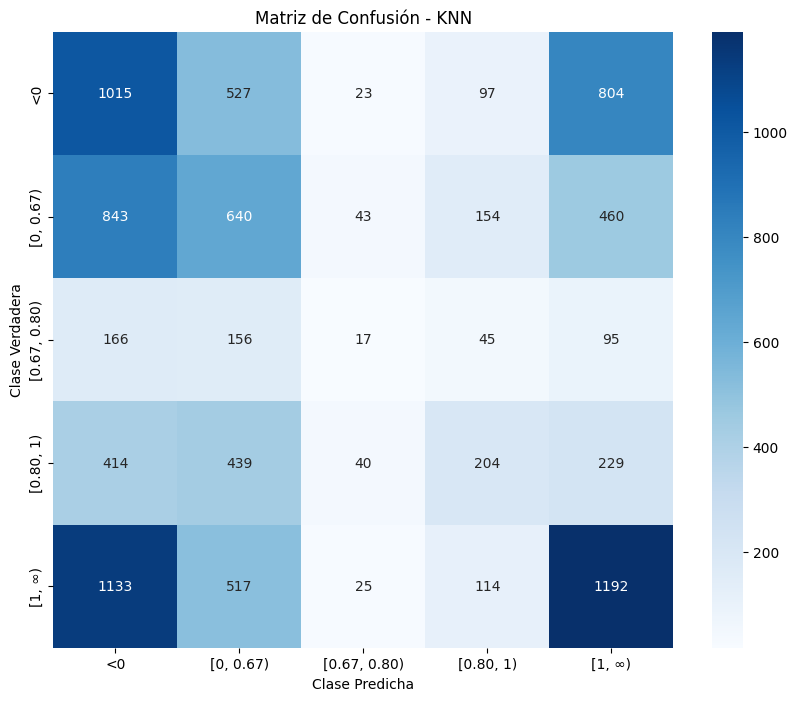

In [ ]:
# Visualizar la Matriz de Confusión
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=label_mapping.values(), columns=label_mapping.values())

    plt.figure(figsize=(10,8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predicha')
    plt.show()

# Matriz de Confusión para KNN
plot_confusion_matrix(y_test, y_pred_knn, 'Matriz de Confusión - KNN')

La matriz de confusión del modelo KNN muestra un desempeño deficiente con una alta cantidad de clasificaciones incorrectas en todas las clases. La clase `<0` presenta una proporción significativa de ejemplos mal clasificados como `[1, ∞]` (804 casos). Estos resultados sugieren que KNN no maneja bien las relaciones entre las clases en este conjunto de datos, posiblemente debido a características mal escaladas, alta dimensionalidad o una elección subóptima del número de vecinos. 

In [ ]:
# Curvas ROC Multiclase
# Binarizar las etiquetas para ROC
y_test_binarized = label_binarize(y_test, classes=list(label_mapping.keys()))
n_classes = y_test_binarized.shape[1]

# Obtener las probabilidades predichas para KNN
y_score_knn = pipeline_knn.predict_proba(X_test)

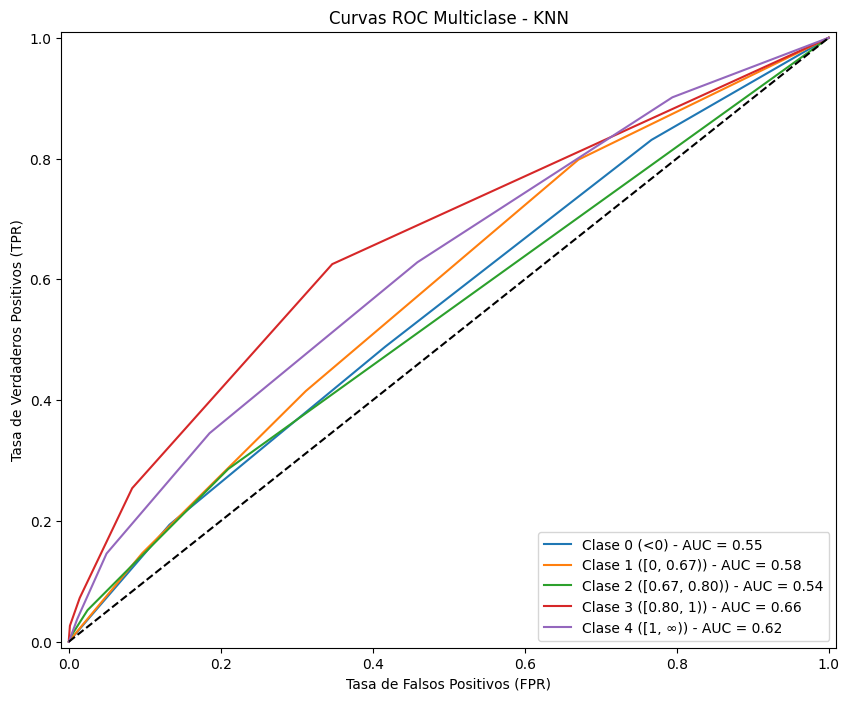

In [ ]:
# Función para plotear Curvas ROC
def plot_roc(y_true, y_score, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Clase {i} ({label_mapping[i]}) - AUC = {roc_auc[i]:0.2f}')

    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Curvas ROC para KNN
plot_roc(y_test_binarized, y_score_knn, 'Curvas ROC Multiclase - KNN')

Las curvas ROC del modelo KNN muestran un desempeño muy limitado para todas las clases, con valores de AUC que oscilan entre 0.54 y 0.66. La clase `[0.80, 1]` (AUC = 0.66) y `[1, ∞]` (AUC = 0.62) tienen el mejor desempeño relativo, aunque siguen siendo bajos para estándares aceptables. Las clases `<0` (AUC = 0.55) y `[0.67, 0.80]` (AUC = 0.54) reflejan una incapacidad para discriminar adecuadamente los ejemplos positivos de negativos. Estas métricas indican que el modelo KNN no puede aprovechar eficazmente la estructura de los datos para diferenciar las clases, probablemente debido a problemas como la elección inadecuada del número de vecinos, datos no normalizados o características poco discriminativas.

In [ ]:
# Guardar el Modelo en Archivo Pickle
with open('modelo_knn.pkl', 'wb') as file:
    pickle.dump(pipeline_knn, file)

# Guardar el Modelo en Archivo Joblib (Opcional pero Recomendado)
joblib.dump(pipeline_knn, 'modelo_knn.joblib')

print("Modelo KNN guardado exitosamente en archivos Pickle y Joblib.")

Modelo KNN guardado exitosamente en archivos Pickle y Joblib.


# Modelamiento 2

## Modelo de regresión logística multinomial

In [ ]:

bins = [-np.inf, 0, 0.67, 0.80, 1, np.inf]
labels = ['<0', '[0, 0.67)', '[0.67, 0.80)', '[0.80, 1)', '[1, ∞)']
data['FDC_FLC_categoria'] = pd.cut(data['FDC/FLC'], bins=bins, labels=labels, right=False)

In [ ]:

categorical_vars = [
    'Estado actual',
    'Concepto del Revisor fiscal en su orme',
    'La compañía está obligada a tener Revisor fiscal?',
    'Tipo societario',
    'Departamento de la dirección del domicilio',
    'Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)'
]

model_numeric_vars = [
    'Cantidad de años de la empresa',
    'Total de activos (Assets)',
    'Razón corriente',
    'Rotación cartera',
    'ROA',
    'ROE',
    'Nivel de endeudamiento',
    'Generación Efectivo',
    'SD',
    'FDC',
    'Tasa de Desempleo',
    'Tasa de Ocupación',
    'PIB DEP'
]

categorical_vars_extended = categorical_vars + ['FDC_FLC_categoria']  # Añadir la variable objetivo
for var in categorical_vars_extended:
    data[var] = data[var].astype('category')

In [ ]:

data = data.sort_values(by=['NIT', 'Fecha de Corte']).reset_index(drop=True)


predictor_vars = categorical_vars + model_numeric_vars

# Para cada variable predictora, creamos una versión rezagada de un año
lagged_data = data.groupby('NIT').shift(1)
lagged_data = lagged_data.add_suffix('_lag1')

In [ ]:

columns_to_drop = [
    'NIT_lag1',                   # Identificador único no es necesario como predictor
    'Fecha de Corte_lag1',        # Variable de tiempo no es necesaria como predictor
    'FDC/FLC_lag1',               # Puede estar correlacionada con la categoría objetivo
    'FDC_FLC_categoria_lag1',      # Variable objetivo rezagada no debe incluirse
    # 'SD_lag1',
    # 'FDC_lag1',
    # 'FLC_lag1'
]
lagged_data = lagged_data.drop(columns=columns_to_drop, errors='ignore')


In [ ]:
data = pd.concat([data, lagged_data], axis=1)
data = data.dropna().reset_index(drop=True)

In [ ]:

lagged_predictor_vars = [var + '_lag1' for var in predictor_vars]
all_predictor_vars = predictor_vars + lagged_predictor_vars

In [ ]:
# Identificar variables numéricas y categóricas entre las predictoras
numeric_features = model_numeric_vars + [var + '_lag1' for var in model_numeric_vars]
categorical_features = categorical_vars + [var + '_lag1' for var in categorical_vars]


In [18]:
 # Crear el transformador para columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [19]:
# 12. Inicializar variables para almacenar métricas
metrics_list = []

# 13. Obtener la lista de años únicos y ordenarlos
years = sorted(data['Fecha de Corte'].unique())

# 14. Inicializar un diccionario para almacenar los modelos entrenados por año (opcional)
trained_models = {}


Procesando el año: 2018
No hay datos de entrenamiento para el año 2018. Saltando...

Procesando el año: 2019


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Año: 2019
ROC AUC: 0.8697
Matriz de Confusión:
[[449  98   0  15 128]
 [110 249   0  43  44]
 [  9  43   4  35   4]
 [ 11  54   4 138  12]
 [ 88  34   0   6 684]]
Reporte de Clasificación:
              precision    recall  f1-score   support

          <0       0.67      0.65      0.66       690
   [0, 0.67)       0.52      0.56      0.54       446
[0.67, 0.80)       0.50      0.04      0.08        95
   [0.80, 1)       0.58      0.63      0.61       219
      [1, ∞)       0.78      0.84      0.81       812

    accuracy                           0.67      2262
   macro avg       0.61      0.54      0.54      2262
weighted avg       0.67      0.67      0.66      2262



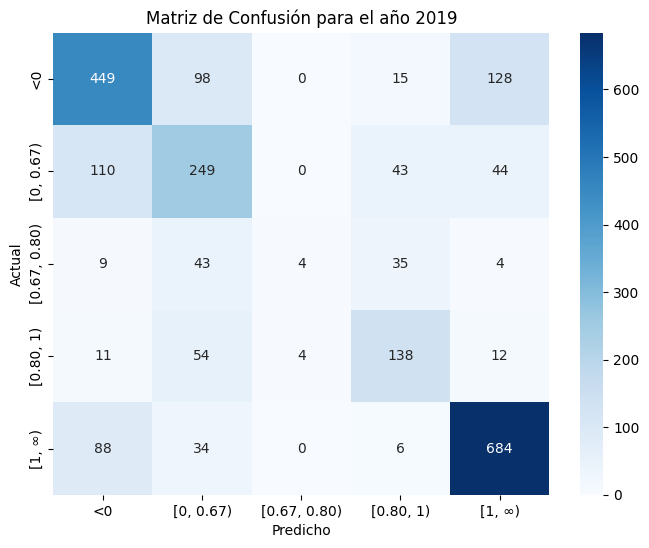

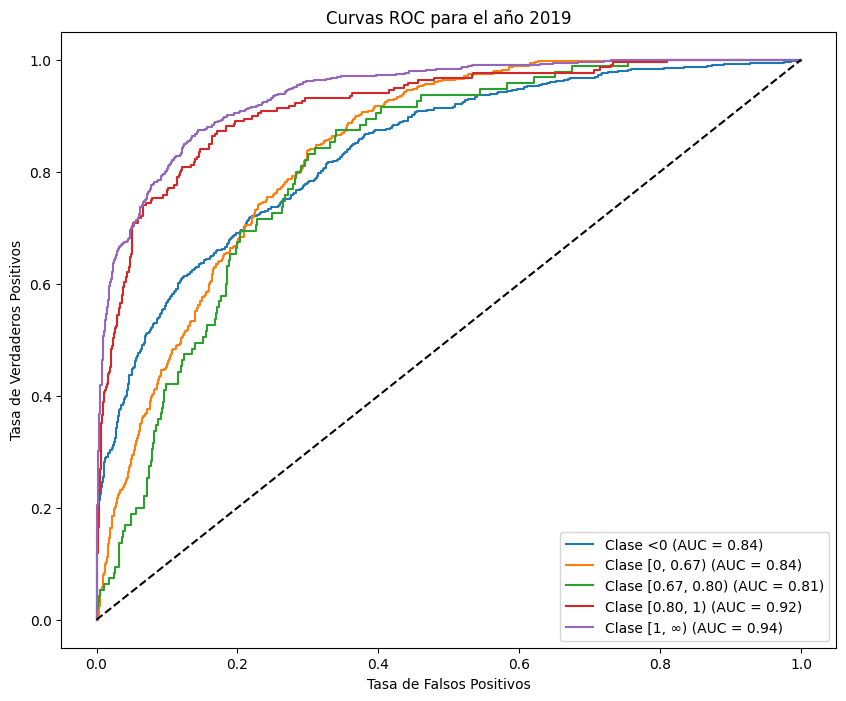


Procesando el año: 2020


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Año: 2020
ROC AUC: 0.8904
Matriz de Confusión:
[[385  37   2   2 363]
 [155 310   4  15 188]
 [  8  71   3  35  31]
 [ 11  77   8 253  53]
 [ 15   6   4   2 955]]
Reporte de Clasificación:
              precision    recall  f1-score   support

          <0       0.67      0.49      0.56       789
   [0, 0.67)       0.62      0.46      0.53       672
[0.67, 0.80)       0.14      0.02      0.04       148
   [0.80, 1)       0.82      0.63      0.71       402
      [1, ∞)       0.60      0.97      0.74       982

    accuracy                           0.64      2993
   macro avg       0.57      0.51      0.52      2993
weighted avg       0.63      0.64      0.61      2993



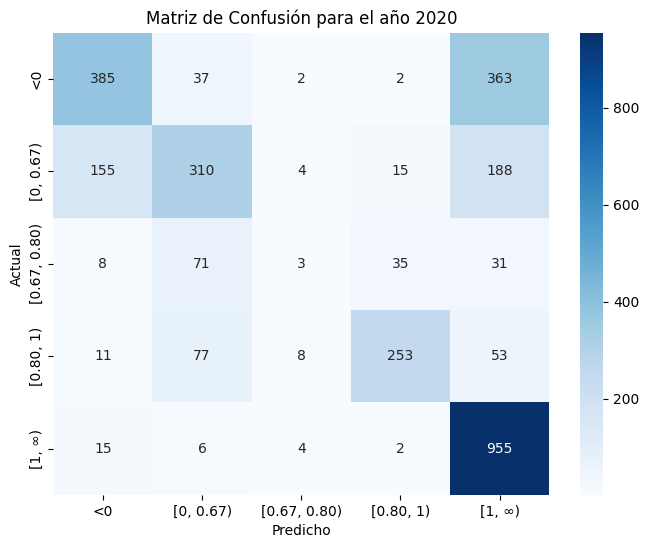

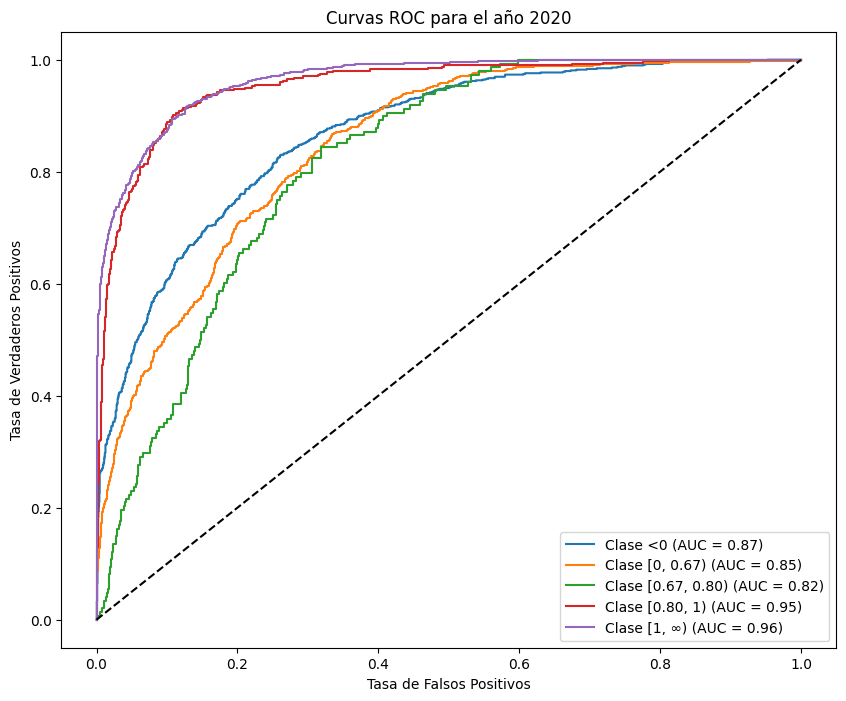


Procesando el año: 2021


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Año: 2021
ROC AUC: 0.8840
Matriz de Confusión:
[[ 567   94    1    2  233]
 [  80  609    4   31   62]
 [   3  141    3   41    8]
 [   5  241    4  214   18]
 [ 112   15    0    1 1005]]
Reporte de Clasificación:
              precision    recall  f1-score   support

          <0       0.74      0.63      0.68       897
   [0, 0.67)       0.55      0.77      0.65       786
[0.67, 0.80)       0.25      0.02      0.03       196
   [0.80, 1)       0.74      0.44      0.56       482
      [1, ∞)       0.76      0.89      0.82      1133

    accuracy                           0.69      3494
   macro avg       0.61      0.55      0.55      3494
weighted avg       0.68      0.69      0.66      3494



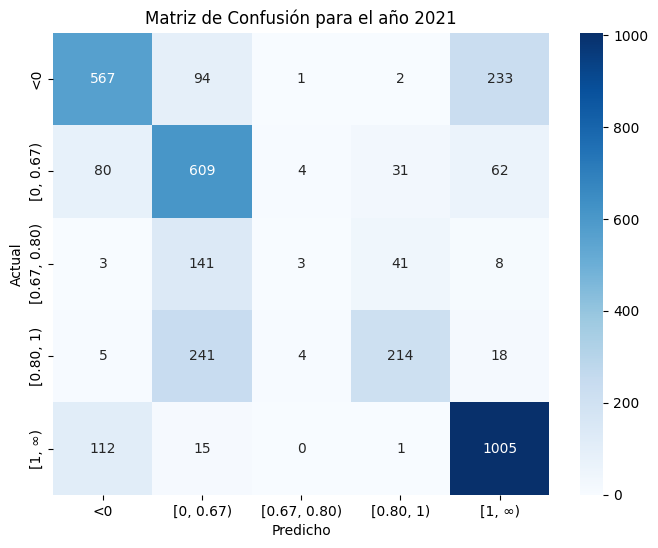

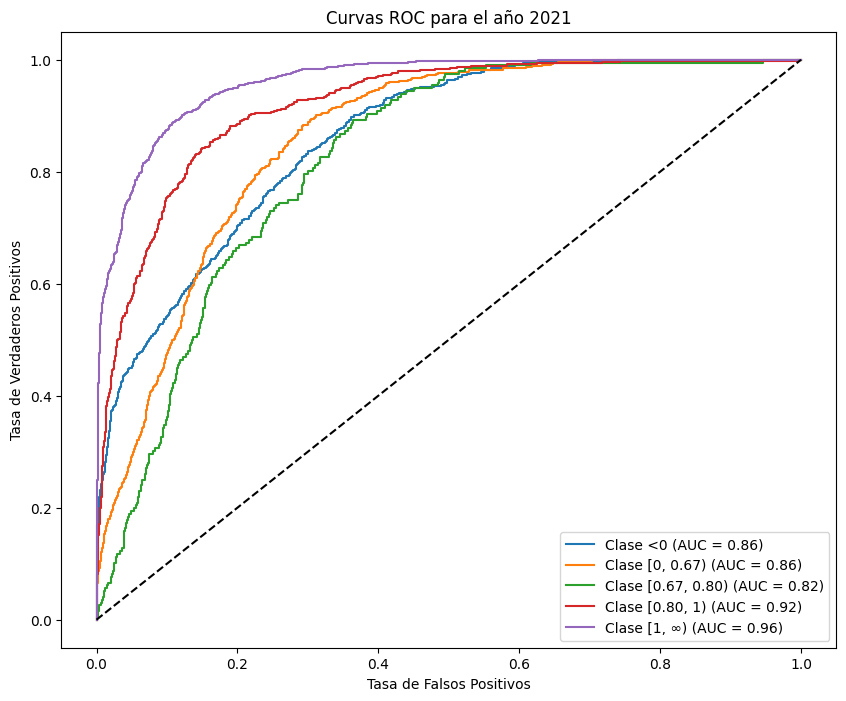


Procesando el año: 2022


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Año: 2022
ROC AUC: 0.9081
Matriz de Confusión:
[[ 522   57    1    2  342]
 [  60  538    4   48  100]
 [   2  115    2   64    7]
 [   2  149    7  365   22]
 [  23   11    0    1 1140]]
Reporte de Clasificación:
              precision    recall  f1-score   support

          <0       0.86      0.56      0.68       924
   [0, 0.67)       0.62      0.72      0.66       750
[0.67, 0.80)       0.14      0.01      0.02       190
   [0.80, 1)       0.76      0.67      0.71       545
      [1, ∞)       0.71      0.97      0.82      1175

    accuracy                           0.72      3584
   macro avg       0.62      0.59      0.58      3584
weighted avg       0.71      0.72      0.69      3584



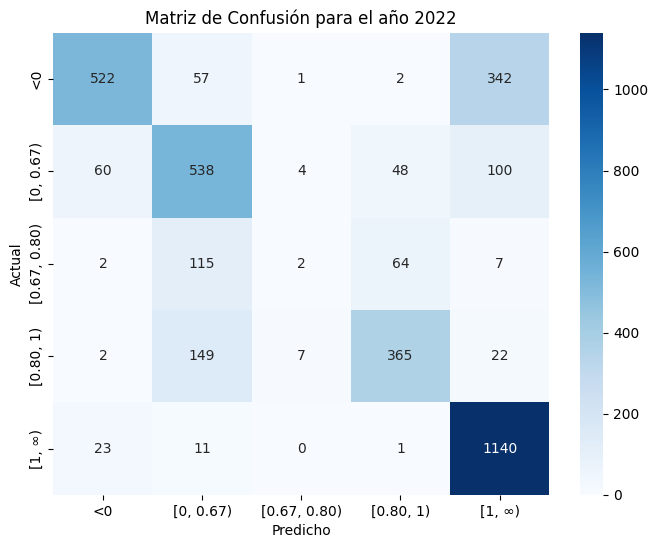

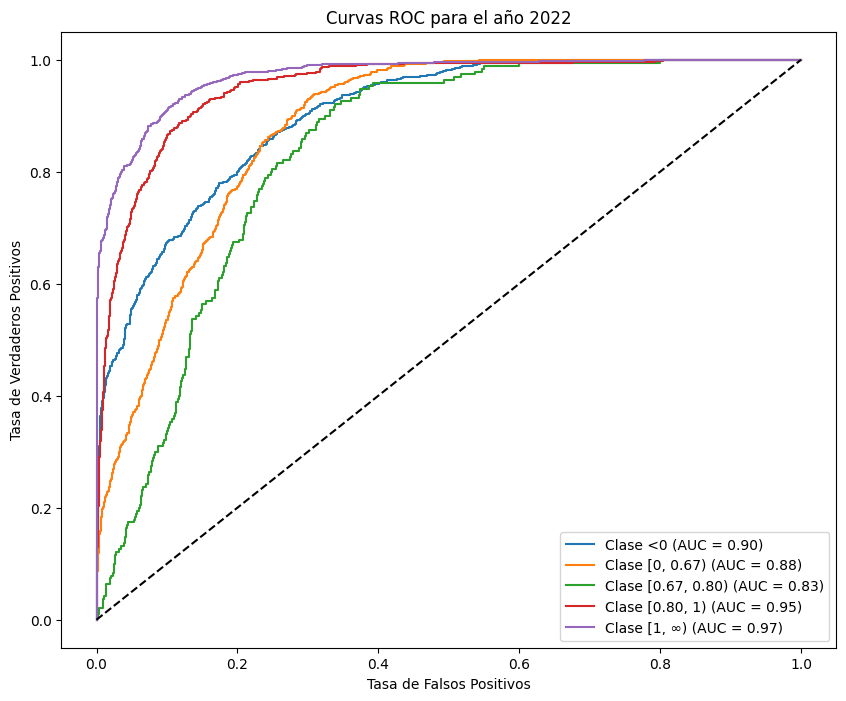


Procesando el año: 2023


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Año: 2023
ROC AUC: 0.9281
Matriz de Confusión:
[[ 809   36    0    2  238]
 [  99  682    5   49   65]
 [   1   93    1   88    2]
 [   1  130    2  326   24]
 [  39    5    1    1 1119]]
Reporte de Clasificación:
              precision    recall  f1-score   support

          <0       0.85      0.75      0.80      1085
   [0, 0.67)       0.72      0.76      0.74       900
[0.67, 0.80)       0.11      0.01      0.01       185
   [0.80, 1)       0.70      0.67      0.69       483
      [1, ∞)       0.77      0.96      0.86      1165

    accuracy                           0.77      3818
   macro avg       0.63      0.63      0.62      3818
weighted avg       0.74      0.77      0.75      3818



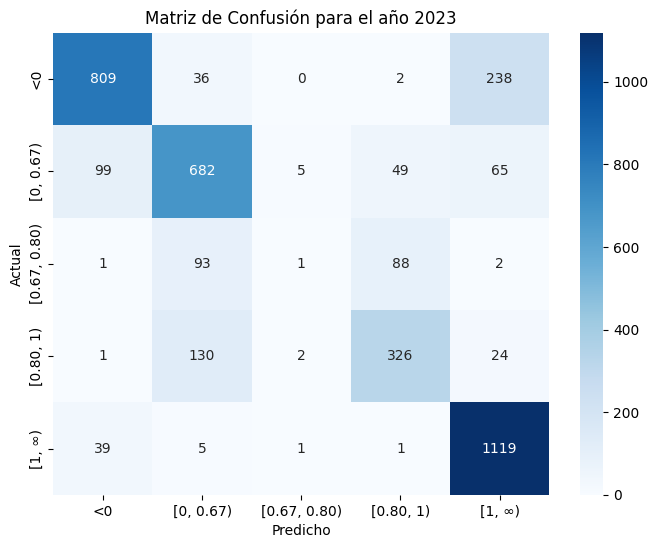

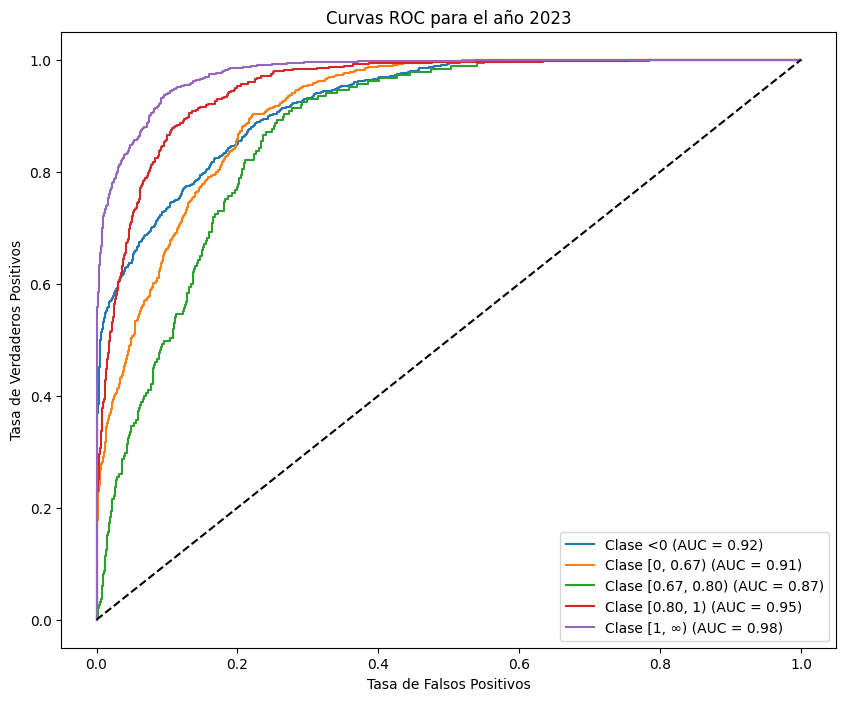

In [ ]:
for i, year in enumerate(years):
    print(f"\nProcesando el año: {year}")

    # Definir el conjunto de entrenamiento: datos de años anteriores a 'year'
    train_data = data[data['Fecha de Corte'] < year]

    # Definir el conjunto de prueba: datos del 'year' actual
    test_data = data[data['Fecha de Corte'] == year]

    # Si no hay datos de entrenamiento, continuar
    if train_data.empty:
        print(f"No hay datos de entrenamiento para el año {year}. Saltando...")
        continue

    # Definir X y y para entrenamiento
    X_train = train_data[all_predictor_vars]
    y_train = train_data['FDC_FLC_categoria']

    # Definir X y y para prueba
    X_test = test_data[all_predictor_vars]
    y_test = test_data['FDC_FLC_categoria']

    # Crear el pipeline con preprocesamiento y modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
    ])

    # Entrenar el modelo
    pipeline.fit(X_train, y_train)

    # Guardar el modelo entrenado para este año (opcional)
    trained_models[year] = pipeline

    # Predecir en el conjunto de prueba
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)

    # Evaluar las métricas
    # Para ROC AUC en clasificación multiclase, se puede usar 'ovo' o 'ovr'
    lb = LabelBinarizer()
    lb.fit(y_train)
    y_test_binarized = lb.transform(y_test)
    if y_test_binarized.shape[1] == 1:
        y_test_binarized = np.hstack((1 - y_test_binarized, y_test_binarized))

    roc_auc = roc_auc_score(y_test_binarized, y_proba, average='macro', multi_class='ovr')

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)

    # Calcular reporte de clasificación
    class_report = classification_report(y_test, y_pred, labels=labels, output_dict=True)

    # Almacenar las métricas
    metrics = {
        'year': year,
        'roc_auc': roc_auc,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }
    metrics_list.append(metrics)

    # Imprimir las métricas para el año actual
    print(f"Año: {year}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Matriz de Confusión:")
    print(conf_matrix)
    print("Reporte de Clasificación:")
    print(classification_report(y_test, y_pred, labels=labels))

    # Graficar la matriz de confusión
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicho')
    plt.title(f'Matriz de Confusión para el año {year}')
    plt.show()

    # Graficar ROC para cada clase
    plt.figure(figsize=(10,8))
    for idx, class_label in enumerate(labels):
        if y_test_binarized.shape[1] > 1:
            fpr, tpr, _ = roc_curve(y_test_binarized[:, idx], y_proba[:, idx])
            roc_auc_class = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Clase {class_label} (AUC = {roc_auc_class:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Curvas ROC para el año {year}')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend(loc='lower right')
    plt.show()


In [25]:
# 16. Crear un DataFrame con las métricas recopiladas
metrics_df = pd.DataFrame(metrics_list)
print("\nResumen de Métricas por Año:")
print(metrics_df[['year', 'roc_auc']])

# Guardar el DataFrame de métricas
metrics_df.to_csv('metrics_summary.csv', index=False)


Resumen de Métricas por Año:
   year   roc_auc
0  2019  0.869704
1  2020  0.890399
2  2021  0.883996
3  2022  0.908142
4  2023  0.928121


In [26]:
last_year = years[-1]
final_model = trained_models.get(last_year, None)

if final_model:
    with open('final_multinomial_logit_model.pkl', 'wb') as file:
        pickle.dump(final_model, file)
    print(f"Modelo entrenado para el año {last_year} guardado como 'final_multinomial_logit_model.pkl'.")
else:
    print("No se encontró un modelo para guardar.")

Modelo entrenado para el año 2023 guardado como 'final_multinomial_logit_model.pkl'.


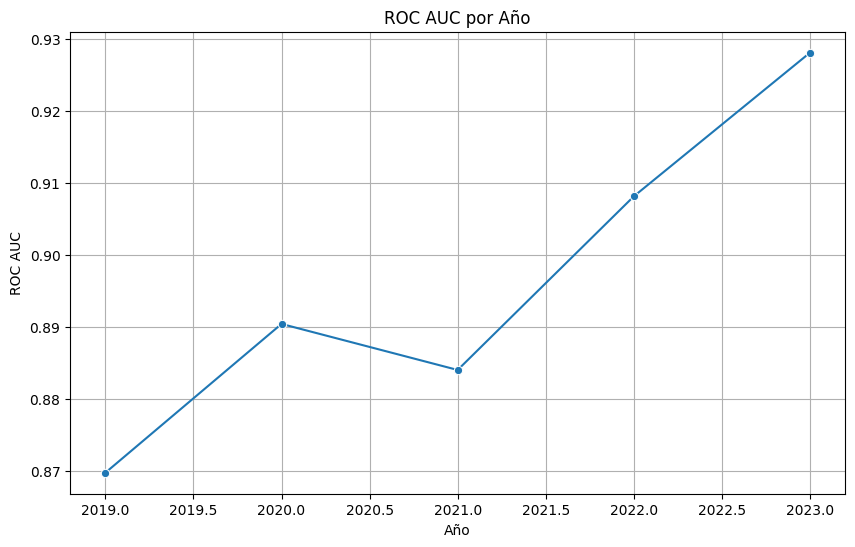

In [27]:
# 18. Opcional: Visualizar las métricas recopiladas
# Por ejemplo, graficar ROC AUC por año
plt.figure(figsize=(10,6))
sns.lineplot(data=metrics_df, x='year', y='roc_auc', marker='o')
plt.title('ROC AUC por Año')
plt.xlabel('Año')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.show()